# Analysis for MD15363

In [276]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from scipy.integrate import cumtrapz 

In [277]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363""/HX:FILLN=10739/")
df = pd.read_parquet(DATADIR)   
#print(df.columns.tolist())
#fbmodes = pd.read_parquet(DATADIR)

In [278]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST" 
CMS_PV = 'CMS:BUNCH_LUMI_INST'
BETASTAR_PV    = "HX:BETASTAR_IP1" #'HX:BETASTAR_IP1', HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'

bids = [20, 500, 1250, 1800,2874]  
#Q1-> 20,500
#Q1.5 --> 1250,1800

## ATLAS BUNCH BY BUNCH LUMINOSITY

### Not normalized

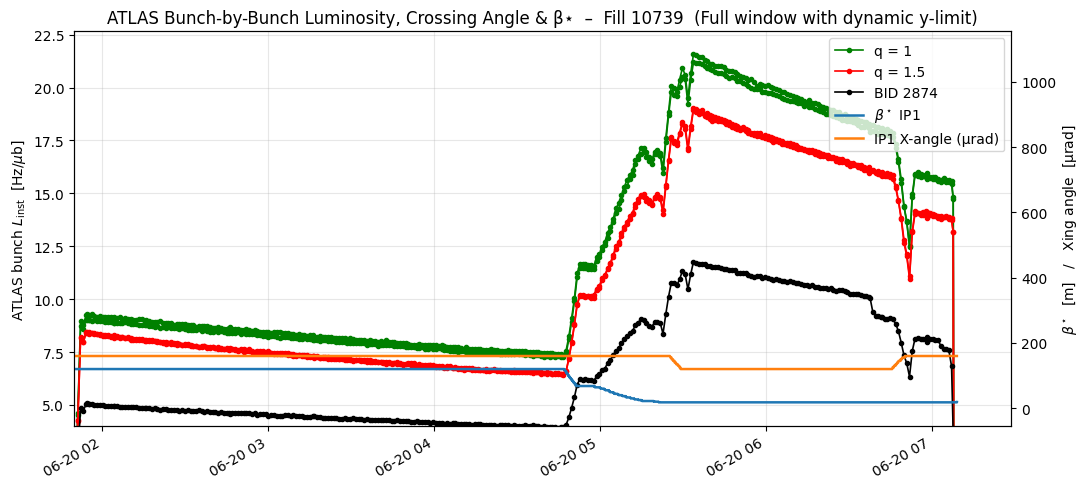

In [279]:
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
dynamic_ylim = True  # Enable dynamic y-axis scaling
title_suffix = "Full window with dynamic y-limit"

# --- Load data ---
def load_bunch_array(pv_name: str, bid_list):
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat    = np.stack(raw[pv_name].values)  # nTimes × 3564
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]
df_atlas = load_bunch_array(ATLAS_PV, all_bids)

df_beta = (
    dd.read_parquet(DATADIR, columns=[BETASTAR_PV])
      .dropna()
      .compute()
)
df_beta.index = pd.to_datetime(df_beta.index, unit="ns")
df_beta.sort_index(inplace=True)

df_xing = (
    dd.read_parquet(DATADIR, columns=[XING_PV])
      .dropna()
      .compute()
)
df_xing.index = pd.to_datetime(df_xing.index, unit="ns")
df_xing.sort_index(inplace=True)

# --- Synchronize time range across datasets ---
t0 = max(df_atlas.index.min(), df_beta.index.min(), df_xing.index.min())
t1 = min(df_atlas.index.max(), df_beta.index.max(), df_xing.index.max())
df_atlas = df_atlas.loc[t0:t1]
df_beta  = df_beta.loc[t0:t1]
df_xing  = df_xing.loc[t0:t1]

# --- Plotting ---
fig, ax_lumi = plt.subplots(figsize=(11, 5))

# Bunch-by-bunch luminosity
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_atlas[[f"B{b}" for b in bids]].plot(
        ax=ax_lumi,
        color=colour,
        linewidth=1.2,
        marker=".",
        legend=False
    )
ax_lumi.plot(
    df_atlas.index,
    df_atlas[f"B{SOLO_BID}"],
    color="black",
    linewidth=1.2,
    marker=".",
    label="_nolegend_"
)
ax_lumi.set_ylabel(r"ATLAS bunch $L_{\rm inst}$  [Hz/$\mu$b]")

# --- Dynamic y-limit ---
if dynamic_ylim:
    y_max = df_atlas.max().max()
    ax_lumi.set_ylim(4, y_max * 1.05)  # 5% headroom
else:
    ax_lumi.set_ylim(4, 9.5)

# Title
ax_lumi.set_title(
    f"ATLAS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
)
ax_lumi.grid(alpha=0.3)

# Right axis: β⋆ and crossing angle
ax_r = ax_lumi.twinx()
df_beta[BETASTAR_PV].plot(
    ax=ax_r, color="tab:blue", linewidth=1.8, label=r"$\beta^\star$ IP1"
)
df_xing[XING_PV].plot(
    ax=ax_r, color="tab:orange", linewidth=1.8, label=r"IP1 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
custom_handles = [
    Line2D([0], [0], color="green", marker=".", linestyle="-", linewidth=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", linestyle="-", linewidth=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", linestyle="-", linewidth=1.2, label="BID 2874"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_lumi.legend(handles=custom_handles, loc="upper right")

# Optional x-range zoom
ax_lumi.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

### Split when beta star changes 

β⋆ starts changing (after 04:00) at: 2025-06-20 04:47:13.295738525


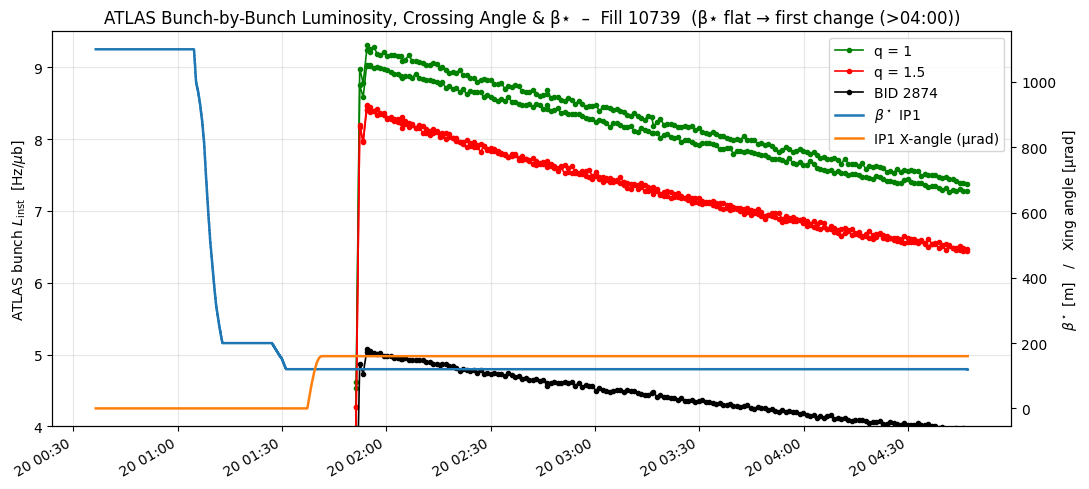

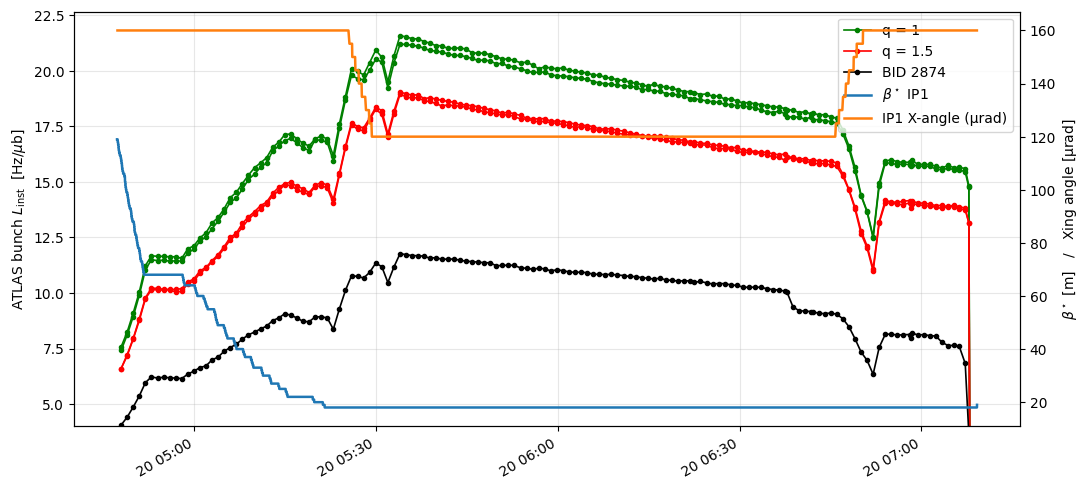

In [280]:
# Find when β⋆ first changes *after 04:00* on that day
tol = 1e-4                                   
day0        = df_beta.index[0].floor("D")    
t_threshold = day0 + pd.Timedelta(hours=4) 
beta_series = df_beta[BETASTAR_PV]
#value that β⋆ still had *at* 04:00 (or the last tick before it)
baseline = beta_series.loc[:t_threshold].iloc[-1]    # safe even if 04:00 not in index
#first time *after* 04:00 that |β⋆−baseline| > tol
after_4h  = beta_series.loc[t_threshold:]
t_change  = after_4h[(after_4h - baseline).abs() > tol].index[0]
print("β⋆ starts changing (after 04:00) at:", t_change)


def plot_window(t_start, t_stop, title_suffix, dynamic_ylim=False):
    sl_atlas = df_atlas.loc[t_start:t_stop]
    sl_beta  = df_beta .loc[t_start:t_stop]
    sl_xing  = df_xing .loc[t_start:t_stop]

    fig, ax_lumi = plt.subplots(figsize=(11, 5))

    # left axis – all bunch curves
    for lbl, (bids, colour) in BUNCH_GROUPS.items():
        sl_atlas[[f"B{b}" for b in bids]].plot(
            ax      = ax_lumi,
            color   = colour,
            lw      = 1.2,
            marker  = ".",
            legend  = False
        )
    ax_lumi.plot(
        sl_atlas.index,
        sl_atlas[f"B{SOLO_BID}"],
        color   = "black",
        lw      = 1.2,
        marker  = ".",
        label   = "_nolegend_"
    )
    ax_lumi.set_ylabel(r"ATLAS bunch $L_{\rm inst}$  [Hz/$\mu$b]")
    if dynamic_ylim:
        y_max = sl_atlas.max().max()
        ax_lumi.set_ylim(4, y_max * 1.05)  # 5% headroom above max
    else:
        ax_lumi.set_ylim(4, 9.5)
    
        ax_lumi.set_title(
        f"ATLAS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
    )
    ax_lumi.grid(alpha=0.3)

    # ----- right axis – β⋆ and crossing angle -----
    ax_r = ax_lumi.twinx()
    sl_beta[BETASTAR_PV].plot(
        ax  = ax_r,
        color = "tab:blue",
        lw    = 1.8,
        label = r"$\beta^\star$ IP1"
    )
    sl_xing[XING_PV].plot(
        ax  = ax_r,
        color = "tab:orange",
        lw    = 1.8,
        label = r"IP1 X-angle (µrad)"
    )
    ax_r.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

    # ----- combined legend (bunch groups + β⋆ + crossing angle) -----
    handles = [
        Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
        Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
        Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
        ax_r.lines[0],     # β⋆
        ax_r.lines[1],     # X-angle
    ]
    ax_lumi.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    return fig
#Draw the two panels: before and after β⋆ begins to change
fig_before = plot_window(df_atlas.index.min(), t_change,
                         "β⋆ flat → first change (>04:00)")
fig_after  = plot_window(t_change, df_atlas.index.max(),
                         "β⋆ changing → end",dynamic_ylim=True)

plt.show()

### Normalized by dividing by max in the beggining

### First split analysis

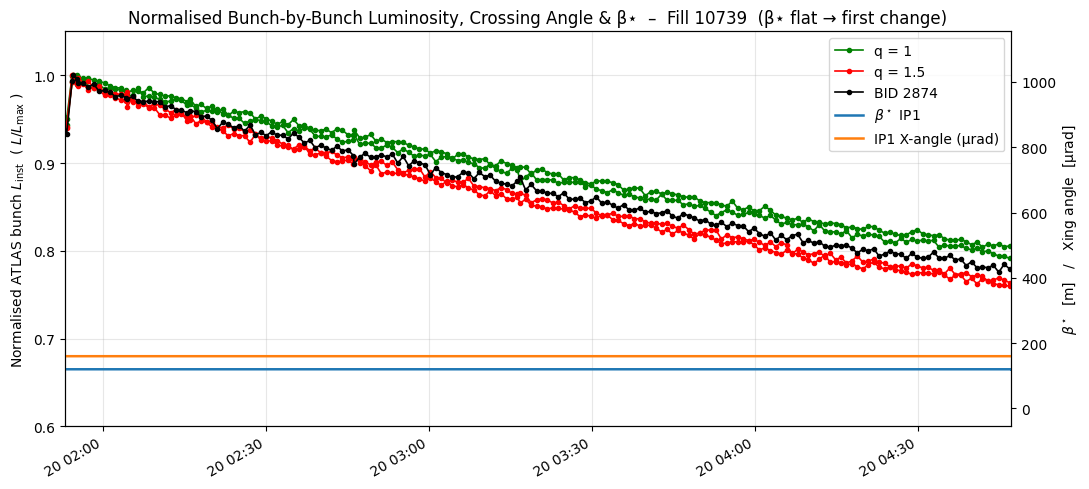

In [281]:
# ────────────────────────────────────────────────────────────────────
# Normalised bunch-by-bunch luminosity during the *first* split
# ────────────────────────────────────────────────────────────────────

# 1) slice the data to the “before β⋆-change” period
df_first   = df_atlas.loc[df_atlas.index.min() : t_change]
beta_first = df_beta .loc[df_beta .index.min() : t_change]
xing_first = df_xing .loc[df_xing .index.min() : t_change]

# 2) per-bunch maxima in that window
max_vals = df_first.max()        # one value per column “B###”

# 3) normalise every bunch curve by its own maximum
df_norm = df_first.div(max_vals)

# 4) plot – same style as the original panel
fig_norm, ax_lum = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm[[f"B{b}" for b in bids]].plot(
        ax     = ax_lum,
        color  = colour,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# solo bunch 2874
ax_lum.plot(
    df_norm.index,
    df_norm[f"B{SOLO_BID}"],
    color  = "black",
    lw     = 1.2,
    marker = ".",
    label  = "_nolegend_"
)

ax_lum.set_ylabel("Normalised ATLAS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )")
ax_lum.set_ylim(0.6, 1.05)
ax_lum.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  (β⋆ flat → first change)"
)
ax_lum.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (unchanged, absolute units)
ax_r = ax_lum.twinx()
beta_first[BETASTAR_PV].plot(
    ax   = ax_r,
    color= "tab:blue",
    lw   = 1.8,
    label= r"$\beta^\star$ IP1"
)
xing_first[XING_PV].plot(
    ax   = ax_r,
    color= "tab:orange",
    lw   = 1.8,
    label= r"IP1 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# combined legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],          # β⋆
    ax_r.lines[1],          # crossing angle
]
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)

# Set x-axis limits
ax_lum.set_xlim([start_time, t_change])
ax_lum.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.show()


#### Raw Integrated Luminosity

/tmp/ipykernel_3339217/377169031.py:6: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_abs[col] = cumtrapz(df_first[col].values, t_sec_first, initial=0.0)


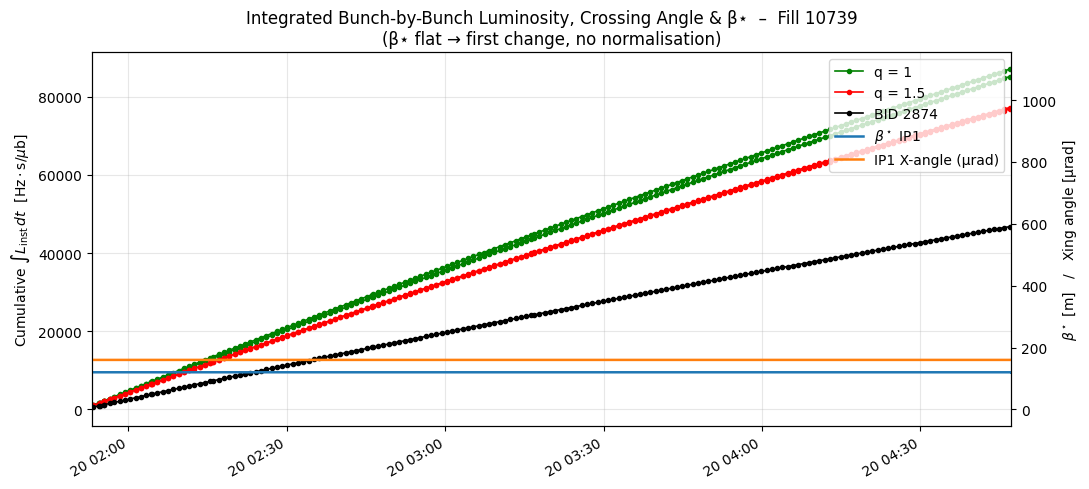

In [282]:
# 1) cumulative ∫L_inst dt for each bunch
t_sec_first = (df_first.index - df_first.index[0]).total_seconds()

cum_abs = {}
for col in df_first.columns:
    cum_abs[col] = cumtrapz(df_first[col].values, t_sec_first, initial=0.0)

df_cum = pd.DataFrame(cum_abs, index=df_first.index)

# 2) plot
fig_int, ax_lum = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum[[f"B{b}" for b in bids]].plot(
        ax=ax_lum, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch 2874
ax_lum.plot(
    df_cum.index, df_cum[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_lum.set_ylabel(r"Cumulative $\int L_{\rm inst}\,dt$  [$\mathrm{Hz\cdot s}/\mu$b]")
ax_lum.set_title(
    "Integrated Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739\n"
    "(β⋆ flat → first change, no normalisation)"
)
ax_lum.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (absolute units, unchanged)
ax_r = ax_lum.twinx()
beta_first[BETASTAR_PV].plot(
    ax=ax_r, color="tab:blue", lw=1.8, label=r"$\beta^\star$ IP1"
)
xing_first[XING_PV].plot(
    ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

# combined legend
handles_int = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],                   # β⋆
    ax_r.lines[1],                   # crossing angle
]
ax_lum.legend(handles=handles_int, loc="upper right")

ax_lum.set_xlim([start_time, t_change])
plt.tight_layout()
plt.show()

In [283]:
final_values = df_cum.iloc[-1]          # last row of the cumulative DataFrame
print("Cumulative luminosity delivered up to β⋆ change:")
print(final_values.to_string(float_format="%.3e"))

Cumulative luminosity delivered up to β⋆ change:
B20     8.518e+04
B500    8.708e+04
B1250   7.726e+04
B1800   7.685e+04
B2874   4.677e+04


In [284]:
def pct_diff(a, b):
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100

final_vals = df_cum.iloc[-1]            

# B20 vs B500  (q = 1)
L20   = final_vals["B20"]
L500  = final_vals["B500"]
pdiff_20_500 = pct_diff(L20, L500)

# B1250 vs B1800  (q = 1.5)
L1250 = final_vals["B1250"]
L1800 = final_vals["B1800"]
pdiff_1250_1800 = pct_diff(L1250, L1800)

print("Final cumulative luminosity (Hz·s / μb) at β⋆ change:")
print(f"  B20   : {L20 : .3e}")
print(f"  B500  : {L500: .3e}   →  % diff: {pdiff_20_500:.2f} %\n")
print(f"  B1250 : {L1250: .3e}")
print(f"  B1800 : {L1800: .3e}   →  % diff: {pdiff_1250_1800:.2f} %")


Final cumulative luminosity (Hz·s / μb) at β⋆ change:
  B20   :  8.518e+04
  B500  :  8.708e+04   →  % diff: 2.21 %

  B1250 :  7.726e+04
  B1800 :  7.685e+04   →  % diff: 0.53 %


In [285]:
def pct_diff(a, b):
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100

mean_q1   = final_vals[["B20", "B500"]].mean()      # q = 1
mean_q15  = final_vals[["B1250", "B1800"]].mean()   # q = 1.5
pdiff_means = pct_diff(mean_q1, mean_q15)

print("Mean cumulative luminosity up to β⋆ change:")
print(f"  q = 1   mean (B20 & B500) : {mean_q1 : .3e}  Hz·s/μb")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15: .3e}  Hz·s/μb")
print(f"\nPercent difference (means, q = 1  vs  q = 1.5): {pdiff_means:.2f} %")


Mean cumulative luminosity up to β⋆ change:
  q = 1   mean (B20 & B500) :  8.613e+04  Hz·s/μb
  q = 1.5 mean (B1250 & B1800):  7.706e+04  Hz·s/μb

Percent difference (means, q = 1  vs  q = 1.5): 11.12 %


#### Normalized to peak Integrated Luminosity
“If this bunch had run at exactly its first-window peak luminosity, how many seconds of that ideal beam time would deliver the same integrated luminosity it actually delivered up to each moment?”

/tmp/ipykernel_3339217/1837660650.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)


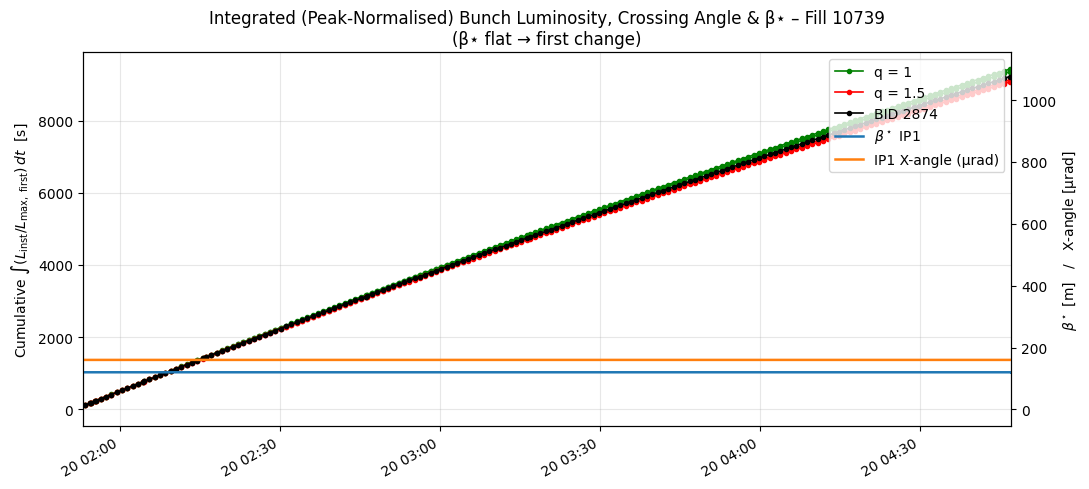

In [286]:
# A)  prepare the first-window data (β⋆ still flat)
df_first   = df_atlas.loc[df_atlas.index.min() : t_change]
beta_first = df_beta  .loc[df_beta.index.min() : t_change]
xing_first = df_xing  .loc[df_xing.index.min() : t_change]
# B)  normalise every bunch by its own maximum in that window
max_vals_first = df_first.max()          # Series: one value per column
df_norm = df_first.div(max_vals_first)   # values now 0-to-1
# C)  cumulative integral of the normalised curves
#     (units -> seconds, since y is dimensionless)
t_sec = (df_norm.index - df_norm.index[0]).total_seconds()
df_cum_norm = pd.DataFrame(
    {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)
     for col in df_norm.columns},
    index=df_norm.index
)
# D)  plot
fig, ax_l = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_peak) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_norm[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )
# solo bunch 2874
ax_l.plot(
    df_cum_norm.index, df_cum_norm[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_title(
    "Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
ax_l.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (unchanged)
ax_r = ax_l.twinx()
beta_first[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP1")
xing_first[XING_PV]    .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# legend – combine bunch groups + β⋆ + X-angle
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],    # β⋆
    ax_r.lines[1],    # crossing angle
]
ax_l.legend(handles=handles, loc="upper right")

# (optional) set the same x-range you used before
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)
ax_l.set_xlim([start_time, t_change])

plt.tight_layout()
plt.show()


#### Statistics

In [287]:
final_values_norm = df_cum_norm.iloc[-1]

print("Peak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm.to_string(float_format="%.3e"))

Peak-normalised cumulative luminosity delivered up to β⋆ change:
B20     9.425e+03
B500    9.354e+03
B1250   9.126e+03
B1800   9.070e+03
B2874   9.219e+03


In [288]:
def rel_pct_diff(a, b):
    """Relative percentage difference w.r.t. the first value (a)."""
    return abs(a - b) / abs(a) * 100          # reference = a

def sym_pct_diff(a, b):
    """Symmetric percentage difference (reference-free)."""
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100   # reference = mean

final_vals_norm = df_cum_norm.iloc[-1]       # units: seconds

# pair 1  (q = 1)
L20,  L500  = final_vals_norm["B20"],  final_vals_norm["B500"]
rel_20_500  = rel_pct_diff(L20, L500)
sym_20_500  = sym_pct_diff(L20, L500)

# pair 2  (q = 1.5)
L1250, L1800 = final_vals_norm["B1250"], final_vals_norm["B1800"]
rel_1250_1800 = rel_pct_diff(L1250, L1800)
sym_1250_1800 = sym_pct_diff(L1250, L1800)

print("Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  B20   : {L20 : .3e} s")
print(f"  B500  : {L500: .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500 :6.4f} %\n")

print(f"  B1250 : {L1250: .3e} s")
print(f"  B1800 : {L1800: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800 :6.4f} %")


Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  9.425e+03 s
  B500  :  9.354e+03 s
    →  relative % diff (ref B20):   0.7606 %
    →  symmetric % diff:            0.7635 %

  B1250 :  9.126e+03 s
  B1800 :  9.070e+03 s
    →  relative % diff (ref B1250): 0.6057 %
    →  symmetric % diff:            0.6075 %


In [289]:
# last row = total (peak-normalised) integrated luminosity (seconds)
final_vals_norm = df_cum_norm.iloc[-1]

group_q1  = ["B20", "B500"]
group_q15 = ["B1250", "B1800"]

tot_q1  = final_vals_norm[group_q1 ].sum()   # or .mean()
tot_q15 = final_vals_norm[group_q15].sum()

sym_pct = sym_pct_diff(tot_q1, tot_q15)
rel_pct = rel_pct_diff(tot_q1, tot_q15)      # now stored in rel_pct

print("Peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):   {tot_q1 : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15: .3e}  s")
print(f"  Symmetric % difference: {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")


Peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):    1.878e+04  s
  q = 1.5 total (B1250 + B1800):  1.820e+04  s
  Symmetric % difference: 3.153 %
  Relative  % difference (ref q=1): 3.104 %


In [290]:
# define your %-difference functions
def sym_pct_diff(a, b):
    """
    Symmetric % difference between a and b:
      100 * (b - a) / ((a + b) / 2)
    """
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """
    Relative % difference of comp vs. ref:
      100 * (comp - ref) / ref
    """
    return 100 * (comp - ref) / ref

# assume df_cum_norm exists and has your cumulative, peak‐normalised data
# grab the last row
final_vals_norm = df_cum_norm.iloc[-1]

# define your two groups
group_q1  = ["B20", "B500"]
group_q15 = ["B1250", "B1800"]

# compute the total (here taken as the mean over each group)
tot_q1   = final_vals_norm[group_q1].mean()
tot_q15  = final_vals_norm[group_q15].mean()

# compute % differences
sym_pct = sym_pct_diff(tot_q1, tot_q15)
rel_pct = rel_pct_diff(tot_q1, tot_q15)

# print results
print("Peak‐normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):    {tot_q1 : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15: .3e}  s")
print(f"  Symmetric % difference:       {sym_pct:.3f} %")
print(f"  Relative % difference (ref q=1): {rel_pct:.3f} %")


Peak‐normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):     9.389e+03  s
  q = 1.5 total (B1250 + B1800):  9.098e+03  s
  Symmetric % difference:       -3.153 %
  Relative % difference (ref q=1): -3.104 %


### Second split analysis

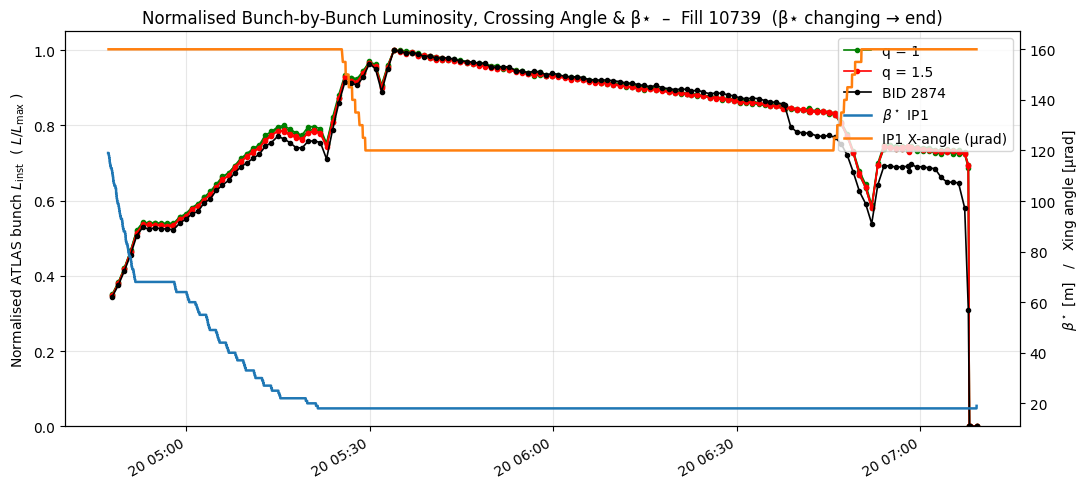

In [291]:
# 1) slice the data to the “after β⋆-change” period
df_second   = df_atlas.loc[t_change : df_atlas.index.max()]
beta_second = df_beta .loc[t_change : df_beta .index.max()]
xing_second = df_xing .loc[t_change : df_xing .index.max()]

# 2) per-bunch maxima in that window
max_vals_2 = df_second.max()          # one value per column “B###”

# 3) normalise every bunch curve by its own maximum
df_norm_2 = df_second.div(max_vals_2)

# 4) plot – same style as before
fig_norm2, ax_lum2 = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm_2[[f"B{b}" for b in bids]].plot(
        ax     = ax_lum2,
        color  = colour,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# solo bunch 2874
ax_lum2.plot(
    df_norm_2.index,
    df_norm_2[f"B{SOLO_BID}"],
    color  = "black",
    lw     = 1.2,
    marker = ".",
    label  = "_nolegend_"
)

ax_lum2.set_ylabel("Normalised ATLAS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )")
ax_lum2.set_ylim(0, 1.05)
ax_lum2.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  (β⋆ changing → end)"
)
ax_lum2.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (absolute units, unchanged)
ax_r2 = ax_lum2.twinx()
beta_second[BETASTAR_PV].plot(
    ax   = ax_r2,
    color= "tab:blue",
    lw   = 1.8,
    label= r"$\beta^\star$ IP1"
)
xing_second[XING_PV].plot(
    ax   = ax_r2,
    color= "tab:orange",
    lw   = 1.8,
    label= r"IP1 X-angle (µrad)"
)
ax_r2.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

# combined legend
handles2 = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r2.lines[0],          # β⋆
    ax_r2.lines[1],          # crossing angle
]
ax_lum2.legend(handles=handles2, loc="upper right")

plt.tight_layout()
plt.show()


#### Integrated Luminosity

/tmp/ipykernel_3339217/2275737703.py:16: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_2[col].values, t_sec_2, initial=0.0)


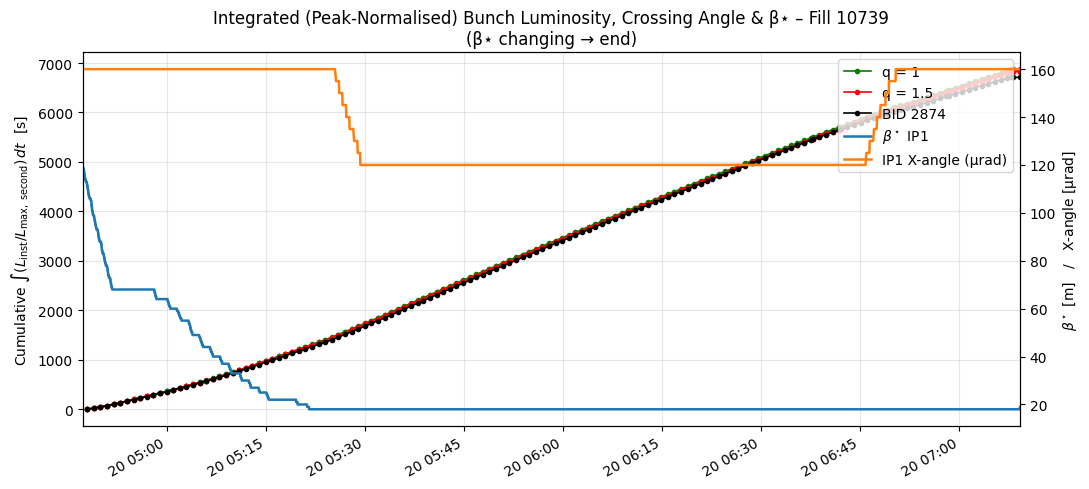

In [292]:
df_second   = df_atlas.loc[t_change : df_atlas.index.max()]
beta_second = df_beta  .loc[t_change : df_beta .index.max()]
xing_second = df_xing  .loc[t_change : df_xing .index.max()]

# ----------------------------------------------------------------
# B)  normalise each bunch by its own maximum in THIS window
# ----------------------------------------------------------------
max_vals_second = df_second.max()              # Series per column
df_norm_2 = df_second.div(max_vals_second)     # values 0-to-1

# ----------------------------------------------------------------
# C)  cumulative integral of the normalised curves
# ----------------------------------------------------------------
t_sec_2 = (df_norm_2.index - df_norm_2.index[0]).total_seconds()
df_cum_norm_2 = pd.DataFrame(
    {col: cumtrapz(df_norm_2[col].values, t_sec_2, initial=0.0)
     for col in df_norm_2.columns},
    index=df_norm_2.index
)

# ----------------------------------------------------------------
# D)  plot
# ----------------------------------------------------------------
fig2, ax_l2 = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_peak-second) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_norm_2[[f"B{b}" for b in bids]].plot(
        ax=ax_l2, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch 2874
ax_l2.plot(
    df_cum_norm_2.index, df_cum_norm_2[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l2.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm second}})\,dt$  [s]"
)
ax_l2.set_title(
    "Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ changing → end)"
)
ax_l2.grid(alpha=0.3)

# right axis – β⋆ and crossing angle during second window
ax_r2 = ax_l2.twinx()
beta_second[BETASTAR_PV].plot(
    ax=ax_r2, color="tab:blue", lw=1.8, label=r"$\beta^\star$ IP1"
)
xing_second[XING_PV].plot(
    ax=ax_r2, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)"
)
ax_r2.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# legend  (two bunch groups + solo + β⋆ + X-angle)
handles2 = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r2.lines[0],     # β⋆
    ax_r2.lines[1],     # crossing angle
]
ax_l2.legend(handles=handles2, loc="upper right")

# optional: zoom from t_change to end (already the slice)
ax_l2.set_xlim([t_change, df_second.index.max()])

plt.tight_layout()
plt.show()

#### Statistics

In [293]:
final_values_norm_2 = df_cum_norm_2.iloc[-1]

print("Peak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm_2.to_string(float_format="%.3e"))

Peak-normalised cumulative luminosity delivered up to β⋆ change:
B20     6.876e+03
B500    6.840e+03
B1250   6.839e+03
B1800   6.827e+03
B2874   6.711e+03


In [294]:
def sym_pct_diff(a, b):
    """
    Symmetric % difference between a and b:
      100 * (b - a) / ((a + b) / 2)
    """
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """
    Relative % difference of comp vs. ref:
      100 * (comp - ref) / ref
    """
    return 100 * (comp - ref) / ref
final_vals_norm_2 = df_cum_norm_2.iloc[-1]    
# pair 1  (q = 1)
L20_2,  L500_2  = final_vals_norm_2["B20"],  final_vals_norm_2["B500"]
rel_20_500_2    = rel_pct_diff(L20_2, L500_2)
sym_20_500_2    = sym_pct_diff(L20_2, L500_2)

# pair 2  (q = 1.5)
L1250_2, L1800_2 = final_vals_norm_2["B1250"], final_vals_norm_2["B1800"]
rel_1250_1800_2  = rel_pct_diff(L1250_2, L1800_2)
sym_1250_1800_2  = sym_pct_diff(L1250_2, L1800_2)

print("Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  B20   : {L20_2  : .3e} s")
print(f"  B500  : {L500_2 : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_2  :8.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_2  :8.4f} %\n")

print(f"  B1250 : {L1250_2: .3e} s")
print(f"  B1800 : {L1800_2: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_2 :8.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_2 :8.4f} %")

Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  6.876e+03 s
  B500  :  6.840e+03 s
    →  relative % diff (ref B20):    -0.5324 %
    →  symmetric % diff:             -0.5338 %

  B1250 :  6.839e+03 s
  B1800 :  6.827e+03 s
    →  relative % diff (ref B1250):  -0.1837 %
    →  symmetric % diff:             -0.1839 %


In [295]:
mean_q1_2  = final_vals_norm_2[["B20", "B500"]].mean()       # q = 1
mean_q15_2 = final_vals_norm_2[["B1250", "B1800"]].mean()    # q = 1.5

# percentage differences
rel_mean_2 = rel_pct_diff(mean_q1_2,  mean_q15_2)          # ref = q1 mean
sym_mean_2 = sym_pct_diff(mean_q1_2, mean_q15_2)           # symmetric
print("Mean peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  q = 1   mean (B20 & B500)   : {mean_q1_2  : .3e}  s")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15_2 : .3e}  s")

print(f"\n  Relative  % diff (ref q = 1 mean): {rel_mean_2:8.4f} %")
print(f"  Symmetric % diff:                  {sym_mean_2:8.4f} %")

Mean peak-normalised cumulative luminosity up to β⋆ change (seconds):

  q = 1   mean (B20 & B500)   :  6.858e+03  s
  q = 1.5 mean (B1250 & B1800):  6.833e+03  s

  Relative  % diff (ref q = 1 mean):  -0.3618 %
  Symmetric % diff:                   -0.3624 %


In [296]:
group_q1_2   = ["B20", "B500"]        # q = 1
group_q15_2  = ["B1250", "B1800"]     # q = 1.5
tot_q1_2  = final_vals_norm_2[group_q1_2 ].sum()
tot_q15_2 = final_vals_norm_2[group_q15_2].sum()
rel_tot_2 = rel_pct_diff(tot_q1_2,  tot_q15_2)   # reference = q1 total
sym_tot_2 = sym_pct_diff(tot_q1_2, tot_q15_2)    # symmetric
print("Peak-normalised cumulative luminosity at β⋆ change (seconds):\n")

print(f"  q = 1   total (B20 + B500)   : {tot_q1_2  : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_2 : .3e}  s")

print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_2:8.4f} %")
print(f"  Symmetric % diff:                    {sym_tot_2:8.4f} %")


Peak-normalised cumulative luminosity at β⋆ change (seconds):

  q = 1   total (B20 + B500)   :  1.372e+04  s
  q = 1.5 total (B1250 + B1800):  1.367e+04  s

  Relative  % diff (ref q = 1 total):  -0.3618 %
  Symmetric % diff:                     -0.3624 %


### Overall

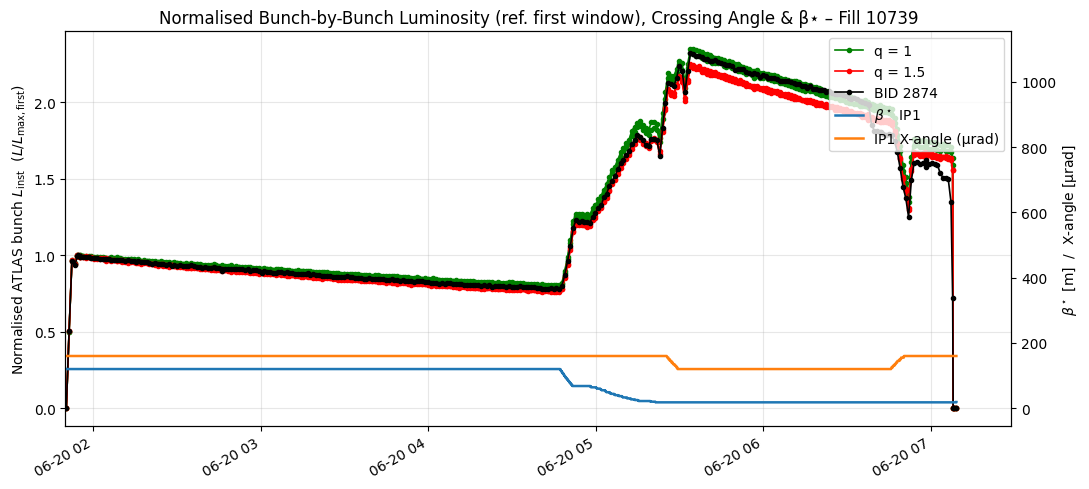

In [297]:

# Normalise the whole fill to the *first-window* peak of each bunch

# 1) reference maxima from the first split (β⋆ flat → t_change)
max_first = df_atlas.loc[t0:t_change].max()

# 2) normalise the *entire* df_atlas by those maxima
df_norm_all = df_atlas.div(max_first)

# 3) plot – same layout as your original figure
pad  = 0.05                                         # 5 % head- & foot-room
ymin = df_norm_all.min().min()
ymax = df_norm_all.max().max()
yrange = ymax - ymin
ylow  = ymin - pad * yrange
yhigh = ymax + pad * yrange

fig, ax_l = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm_all[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

ax_l.plot(
    df_norm_all.index, df_norm_all[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(
    r"Normalised ATLAS bunch $L_{\rm inst}$  ($L/L_{\max,\mathrm{first}}$)"
)
ax_l.set_ylim(ylow, yhigh)                          # ⬅ dynamic limits
ax_l.set_title(
    "Normalised Bunch-by-Bunch Luminosity (ref. first window), "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l.grid(alpha=0.3)

# right-axis traces stay the same
ax_r = ax_l.twinx()
df_beta[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP1")
df_xing[XING_PV]   .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0], ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")
ax_l.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

#### Integrated luminosity

/tmp/ipykernel_3339217/714372587.py:4: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_all[col].values, t_sec_all, initial=0.0)


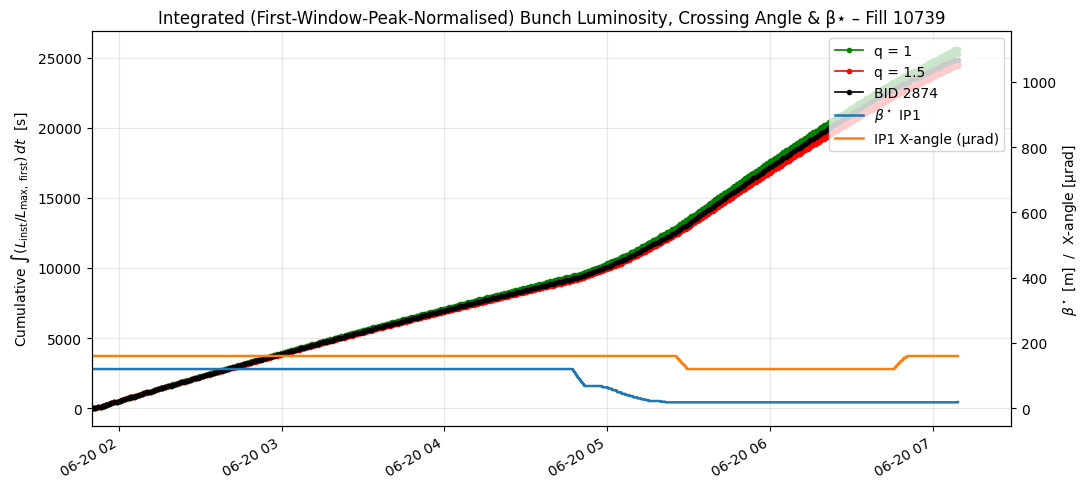

In [298]:
# 1) cumulative integral for each bunch
t_sec_all = (df_norm_all.index - df_norm_all.index[0]).total_seconds()
df_cum_all_atlas = pd.DataFrame(
    {col: cumtrapz(df_norm_all[col].values, t_sec_all, initial=0.0)
     for col in df_norm_all.columns},
    index=df_norm_all.index
)

# 2) dynamic y-range (±5 % padding)
pad = 0.05
ymin, ymax = df_cum_all_atlas.min().min(), df_cum_all_atlas.max().max()
yrange     = ymax - ymin
ylow, yhigh = ymin - pad*yrange, ymax + pad*yrange

# 3) plot
fig_int, ax_l = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_all_atlas[[f"B{b}" for b in bids]].plot(
        ax=ax_l,
        color=colour,
        lw=1.2,
        marker=".",
        label=lbl
    )

# 2) plot the solo bunch
ax_l.plot(
    df_cum_all_atlas.index,
    df_cum_all_atlas[f"B{SOLO_BID}"],
    color="black",
    lw=1.2,
    marker=".",
    label="_nolegend_"   # or f"Solo BID {SOLO_BID}" if you *do* want it in the legend
)
ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_ylim(ylow, yhigh)
ax_l.set_title(
    "Integrated (First-Window-Peak-Normalised) Bunch Luminosity, "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l.grid(alpha=0.3)

# right axis – β⋆ & crossing angle
ax_r = ax_l.twinx()
df_beta[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP1")
df_xing[XING_PV]   .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# combined legend
handles = [
    Line2D([0],[0],color="green",marker=".",lw=1.2,label="q = 1"),
    Line2D([0],[0],color="red",  marker=".",lw=1.2,label="q = 1.5"),
    Line2D([0],[0],color="black",marker=".",lw=1.2,label=f"BID {SOLO_BID}"),
    ax_r.lines[0], ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")
ax_l.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

#### Statistics

In [299]:
final_values_norm_all_atlas = df_cum_all_atlas.iloc[-1]   # units: seconds

print("Peak-normalised cumulative luminosity delivered over the whole fill:")
print(final_values_norm_all_atlas.to_string(float_format="%.3e"))

Peak-normalised cumulative luminosity delivered over the whole fill:
B20     2.560e+04
B500    2.526e+04
B1250   2.455e+04
B1800   2.437e+04
B2874   2.483e+04


In [300]:
def sym_pct_diff(a, b):
    """
    Symmetric % difference between a and b:
      100 * (b - a) / ((a + b) / 2)
    """
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """
    Relative % difference of comp vs. ref:
      100 * (comp - ref) / ref
    """
    return 100 * (comp - ref) / ref
final_vals_norm_all_atlas = df_cum_all_atlas.iloc[-1] 
# pair 1  (q = 1)
L20_all,  L500_all   = final_vals_norm_all_atlas["B20"],  final_vals_norm_all_atlas["B500"]
rel_20_500_all       = rel_pct_diff(L20_all, L500_all)
sym_20_500_all       = sym_pct_diff(L20_all, L500_all)
# pair 2  (q = 1.5)
L1250_all, L1800_all = final_vals_norm_all_atlas["B1250"], final_vals_norm_all_atlas["B1800"]
rel_1250_1800_all    = rel_pct_diff(L1250_all, L1800_all)
sym_1250_1800_all    = sym_pct_diff(L1250_all, L1800_all)

print("Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  B20   : {L20_all   : .3e} s")
print(f"  B500  : {L500_all  : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_all :8.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_all :8.4f} %\n")

print(f"  B1250 : {L1250_all : .3e} s")
print(f"  B1800 : {L1800_all : .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_all :8.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_all :8.4f} %")


Peak-normalised cumulative luminosity over the whole fill (seconds):

  B20   :  2.560e+04 s
  B500  :  2.526e+04 s
    →  relative % diff (ref B20):    -1.3429 %
    →  symmetric % diff:             -1.3519 %

  B1250 :  2.455e+04 s
  B1800 :  2.437e+04 s
    →  relative % diff (ref B1250):  -0.6958 %
    →  symmetric % diff:             -0.6982 %


In [301]:
# means of the two bunches in each q-group
mean_q1_all   = final_vals_norm_all_atlas[["B20", "B500"]].mean()      # q = 1
mean_q15_all  = final_vals_norm_all_atlas[["B1250", "B1800"]].mean()   # q = 1.5

# percentage differences
rel_mean_all  = rel_pct_diff(mean_q1_all,  mean_q15_all)     # ref = q1 mean
sym_mean_all  = sym_pct_diff(mean_q1_all, mean_q15_all)      # symmetric
print("Mean peak-normalised cumulative luminosity over the whole fill (seconds):\n")

print(f"  q = 1   mean (B20 & B500)   : {mean_q1_all  : .3e}  s")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15_all : .3e}  s")

print(f"\n  Relative  % diff (ref q = 1 mean): {rel_mean_all:8.4f} %")
print(f"  Symmetric % diff:                  {sym_mean_all:8.4f} %")

Mean peak-normalised cumulative luminosity over the whole fill (seconds):

  q = 1   mean (B20 & B500)   :  2.543e+04  s
  q = 1.5 mean (B1250 & B1800):  2.446e+04  s

  Relative  % diff (ref q = 1 mean):  -3.8045 %
  Symmetric % diff:                   -3.8783 %


In [302]:
group_q1_all   = ["B20", "B500"]        # q = 1
group_q15_all  = ["B1250", "B1800"]     # q = 1.5

tot_q1_all  = final_vals_norm_all[group_q1_all ].sum()
tot_q15_all = final_vals_norm_all[group_q15_all].sum()
rel_tot_all = rel_pct_diff(tot_q1_all,  tot_q15_all)   # reference = q1 total
sym_tot_all = sym_pct_diff(tot_q1_all, tot_q15_all)    # symmetric

print("Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  q = 1   total (B20 + B500)   : {tot_q1_all  : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_all : .3e}  s")
print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_all:8.4f} %")
print(f"  Symmetric % diff:                    {sym_tot_all:8.4f} %")

Peak-normalised cumulative luminosity over the whole fill (seconds):

  q = 1   total (B20 + B500)   :  5.202e+04  s
  q = 1.5 total (B1250 + B1800):  4.989e+04  s

  Relative  % diff (ref q = 1 total):  -4.0928 %
  Symmetric % diff:                     -4.1783 %


## CMS Luminosity

In [303]:
CMS_PV = 'CMS:BUNCH_LUMI_INST'

### Not Normalized, Full window

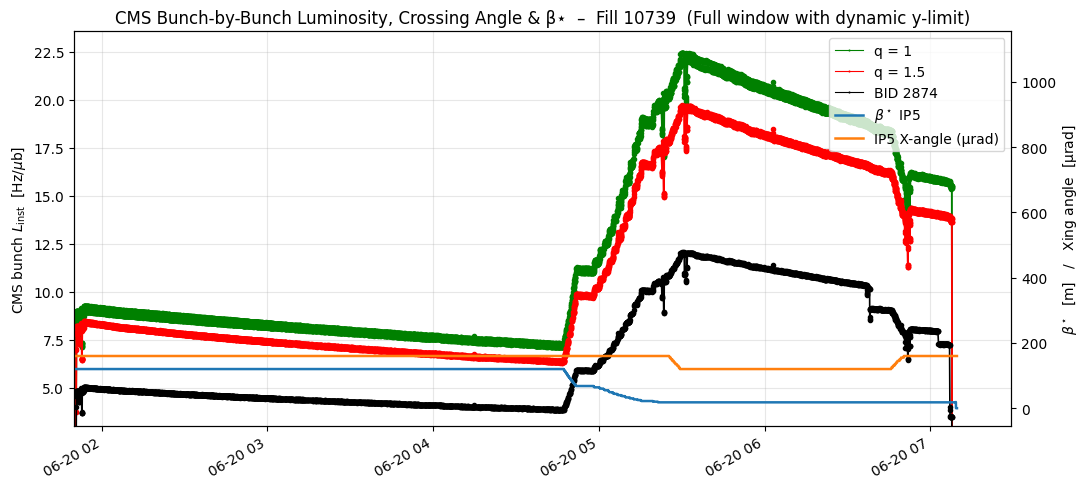

In [304]:
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
dynamic_ylim = True  # Enable dynamic y-axis scaling
title_suffix = "Full window with dynamic y-limit"

# --- Load CMS bunch-by-bunch data ---
def load_bunch_array(pv_name: str, bid_list):
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat    = np.stack(raw[pv_name].values)  # nTimes × 3564
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

# --- Bunches to load ---
all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]
df_cms = load_bunch_array(CMS_PV, all_bids)  # << switched from df_atlas → df_cms

# --- Load machine parameters ---
df_beta = (
    dd.read_parquet(DATADIR, columns=[BETASTAR_PV])
      .dropna()
      .compute()
)
df_beta.index = pd.to_datetime(df_beta.index, unit="ns")
df_beta.sort_index(inplace=True)

df_xing = (
    dd.read_parquet(DATADIR, columns=[XING_PV])
      .dropna()
      .compute()
)
df_xing.index = pd.to_datetime(df_xing.index, unit="ns")
df_xing.sort_index(inplace=True)

# --- Synchronize time range ---
t0 = max(df_cms.index.min(), df_beta.index.min(), df_xing.index.min())
t1 = min(df_cms.index.max(), df_beta.index.max(), df_xing.index.max())
df_cms = df_cms.loc[t0:t1]
df_beta = df_beta.loc[t0:t1]
df_xing = df_xing.loc[t0:t1]

# --- Plotting ---
fig, ax_lumi = plt.subplots(figsize=(11, 5))

# Left axis: CMS bunch-by-bunch luminosity
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cms[[f"B{b}" for b in bids]].plot(
        ax=ax_lumi,
        color=colour,
        linewidth=1.2,
        marker=".",
        legend=False
    )
ax_lumi.plot(
    df_cms.index,
    df_cms[f"B{SOLO_BID}"],
    color="black",
    linewidth=1.2,
    marker=".",
    label="_nolegend_"
)
ax_lumi.set_ylabel(r"CMS bunch $L_{\rm inst}$  [Hz/$\mu$b]")  # << updated label

# Y-limit: dynamic if enabled
if dynamic_ylim:
    y_max = df_cms.max().max()
    ax_lumi.set_ylim(3, y_max * 1.05)
else:
    ax_lumi.set_ylim(3, 9.5)

# Title
ax_lumi.set_title(
    f"CMS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
)  # << updated title
ax_lumi.grid(alpha=0.3)

# Right axis: β⋆ and X-angle
ax_r = ax_lumi.twinx()
df_beta[BETASTAR_PV].plot(
    ax=ax_r, color="tab:blue", linewidth=1.8, label=r"$\beta^\star$ IP5"
)  # << updated to IP5 for CMS
df_xing[XING_PV].plot(
    ax=ax_r, color="tab:orange", linewidth=1.8, label=r"IP5 X-angle (µrad)"
)  # << updated to IP5
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
custom_handles = [
    Line2D([0], [0], color="green", marker=".",markersize=1, linestyle="-", linewidth=0.8, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".",markersize=1, linestyle="-", linewidth=0.8, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".",markersize=1, linestyle="-", linewidth=0.8, label="BID 2874"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_lumi.legend(handles=custom_handles, loc="upper right")

# Optional x-range zoom
ax_lumi.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


### Split

β⋆ starts changing (after 04:00) at: 2025-06-20 04:47:13.295738525


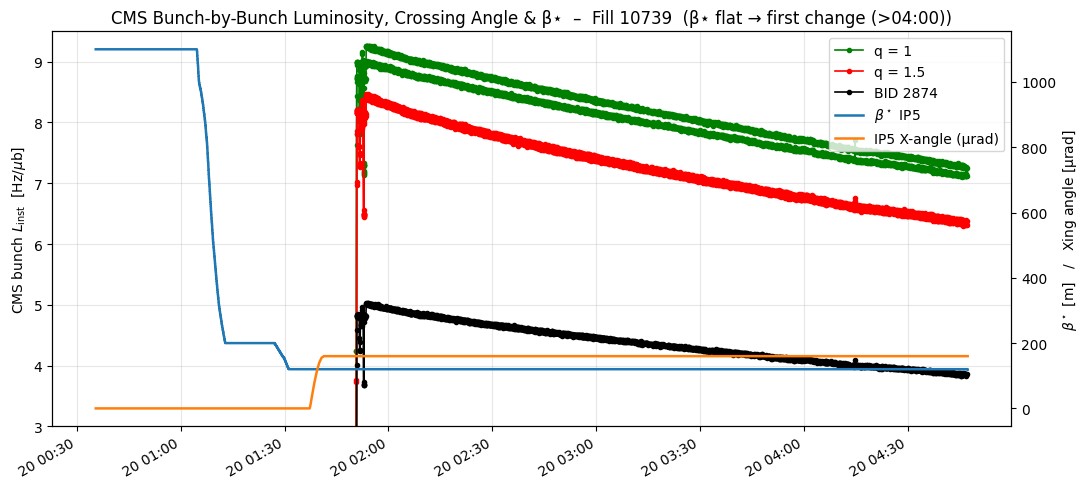

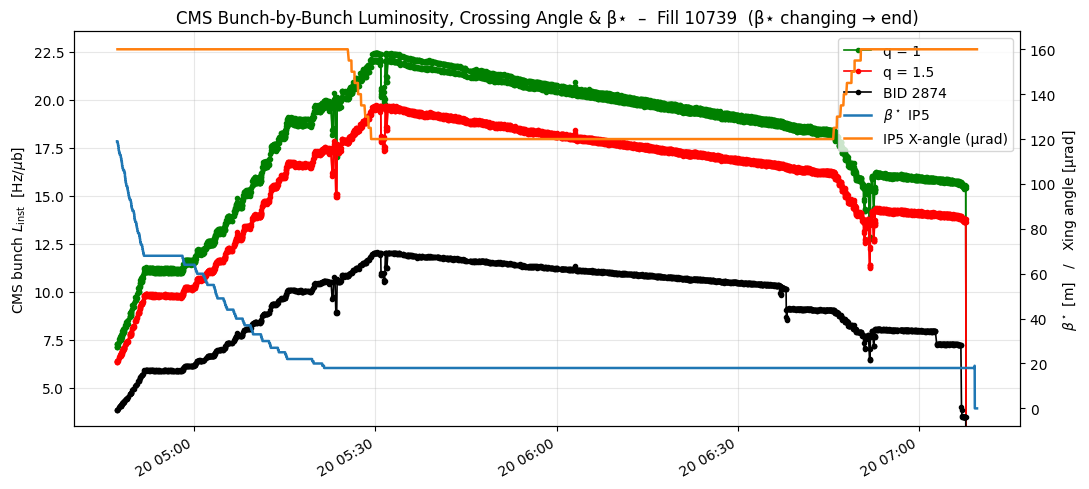

In [305]:
# --- Detect β⋆ change ---
tol = 1e-4                                   
day0        = df_beta.index[0].floor("D")    
t_threshold = day0 + pd.Timedelta(hours=4) 
beta_series = df_beta[BETASTAR_PV]

baseline = beta_series.loc[:t_threshold].iloc[-1]  # value at or before 04:00
after_4h  = beta_series.loc[t_threshold:]
t_change  = after_4h[(after_4h - baseline).abs() > tol].index[0]

print("β⋆ starts changing (after 04:00) at:", t_change)

# --- Plotting Function ---
def plot_window(t_start, t_stop, title_suffix, dynamic_ylim=False):
    sl_cms  = df_cms.loc[t_start:t_stop]
    sl_beta = df_beta.loc[t_start:t_stop]
    sl_xing = df_xing.loc[t_start:t_stop]

    fig, ax_lumi = plt.subplots(figsize=(11, 5))

    # Left axis – CMS bunches
    for lbl, (bids, colour) in BUNCH_GROUPS.items():
        sl_cms[[f"B{b}" for b in bids]].plot(
            ax=ax_lumi,
            color=colour,
            lw=1.2,
            marker=".",
            legend=False
        )
    ax_lumi.plot(
        sl_cms.index,
        sl_cms[f"B{SOLO_BID}"],
        color="black",
        lw=1.2,
        marker=".",
        label="_nolegend_"
    )

    ax_lumi.set_ylabel(r"CMS bunch $L_{\rm inst}$  [Hz/$\mu$b]")
    if dynamic_ylim:
        y_max = sl_cms.max().max()
        ax_lumi.set_ylim(3, y_max * 1.05)
    else:
        ax_lumi.set_ylim(3, 9.5)

    ax_lumi.set_title(
        f"CMS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
    )
    ax_lumi.grid(alpha=0.3)

    # Right axis – β⋆ and crossing angle
    ax_r = ax_lumi.twinx()
    sl_beta[BETASTAR_PV].plot(
        ax=ax_r,
        color="tab:blue",
        lw=1.8,
        label=r"$\beta^\star$ IP5"
    )
    sl_xing[XING_PV].plot(
        ax=ax_r,
        color="tab:orange",
        lw=1.8,
        label=r"IP5 X-angle (µrad)"
    )
    ax_r.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

    # Combined legend
    handles = [
        Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
        Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
        Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
        ax_r.lines[0],
        ax_r.lines[1],
    ]
    ax_lumi.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    return fig

# --- Draw plots ---
fig_before = plot_window(df_cms.index.min(), t_change,
                         "β⋆ flat → first change (>04:00)")

fig_after  = plot_window(t_change, df_cms.index.max(),
                         "β⋆ changing → end", dynamic_ylim=True)

plt.show()


### first window analysis

#### normalized by maximum

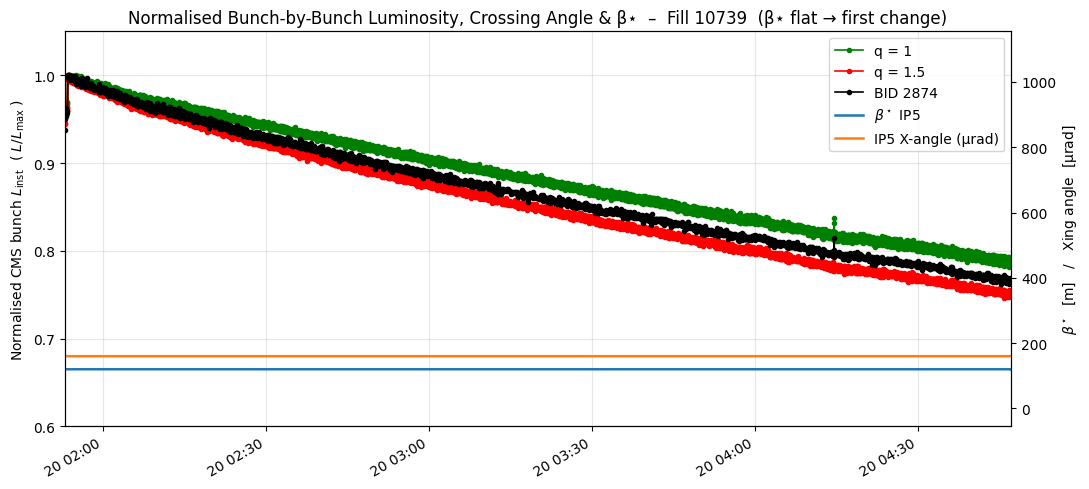

In [306]:
# 1) slice the data to the “before β⋆-change” period
df_first   = df_cms.loc[df_cms.index.min() : t_change]
beta_first = df_beta.loc[df_beta.index.min() : t_change]
xing_first = df_xing.loc[df_xing.index.min() : t_change]

# 2) per-bunch maxima in that window
max_vals = df_first.max()  # one value per column “B###”

# 3) normalise every bunch curve by its own maximum
df_norm = df_first.div(max_vals)

# 4) plot – same style as original, now for CMS
fig_norm, ax_lum = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm[[f"B{b}" for b in bids]].plot(
        ax=ax_lum,
        color=colour,
        lw=1.2,
        marker=".",
        legend=False
    )

# solo bunch
ax_lum.plot(
    df_norm.index,
    df_norm[f"B{SOLO_BID}"],
    color="black",
    lw=1.2,
    marker=".",
    label="_nolegend_"
)

# Axis labels and title
ax_lum.set_ylabel("Normalised CMS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )")
ax_lum.set_ylim(0.6, 1.05)
ax_lum.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  (β⋆ flat → first change)"
)
ax_lum.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle
ax_r = ax_lum.twinx()
beta_first[BETASTAR_PV].plot(
    ax=ax_r,
    color="tab:blue",
    lw=1.8,
    label=r"$\beta^\star$ IP5"
)
xing_first[XING_PV].plot(
    ax=ax_r,
    color="tab:orange",
    lw=1.8,
    label=r"IP5 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],
    ax_r.lines[1],
]

# X-axis zoom
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)
ax_lum.set_xlim([start_time, t_change])

ax_lum.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.show()


#### integrated Luminosity

/tmp/ipykernel_3339217/2598838936.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)


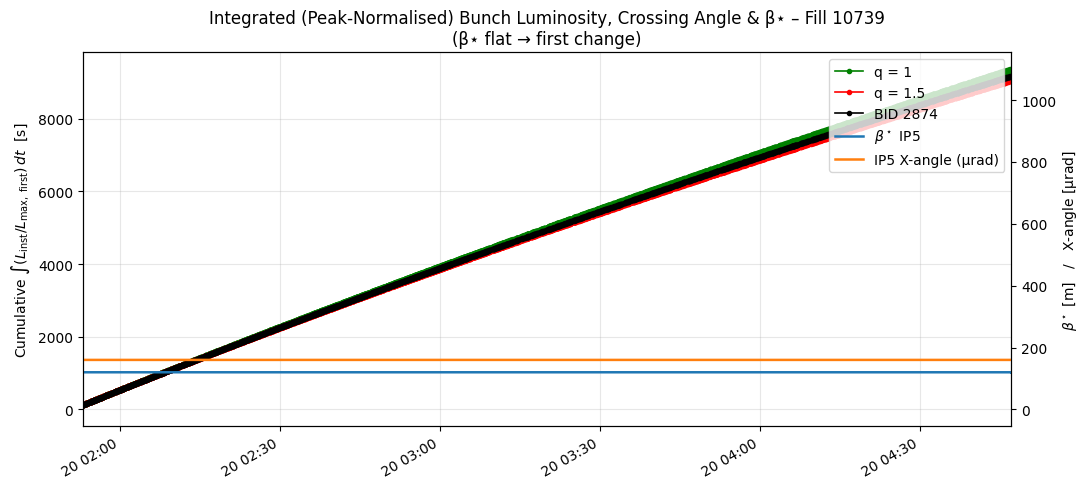

In [307]:
# A) Slice data before β⋆ changes
df_first   = df_cms.loc[df_cms.index.min() : t_change]
beta_first = df_beta.loc[df_beta.index.min() : t_change]
xing_first = df_xing.loc[df_xing.index.min() : t_change]

# B) Normalise each bunch by its own maximum in that window
max_vals_first = df_first.max()
df_norm = df_first.div(max_vals_first)

# C) Compute cumulative integral (in seconds, dimensionless y)
t_sec = (df_norm.index - df_norm.index[0]).total_seconds()
df_cum_norm = pd.DataFrame(
    {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)
     for col in df_norm.columns},
    index=df_norm.index
)

# D) Plotting
fig, ax_l = plt.subplots(figsize=(11, 5))

# Left axis – cumulative ∫(L / L_max) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_norm[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

# Solo bunch 2874
ax_l.plot(
    df_cum_norm.index, df_cum_norm[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_title(
    "Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
ax_l.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle
ax_r = ax_l.twinx()
beta_first[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP5")
xing_first[XING_PV]    .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP5 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# Combined legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")

# Optional x-axis zoom (same as other plots)
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)
ax_l.set_xlim([start_time, t_change])

plt.tight_layout()
plt.show()


#### statistics

In [308]:
# Final values (at β⋆ change)
final_values_norm = df_cum_norm.iloc[-1]

print("CMS: Peak-normalised cumulative luminosity delivered up to β⋆ change:\n")
print(final_values_norm.to_string(float_format="%.3e"))

def sym_pct_diff(a, b):
    """
    Symmetric % difference between a and b:
      100 * (b - a) / ((a + b) / 2)
    """
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """
    Relative % difference of comp vs. ref:
      100 * (comp - ref) / ref
    """
    return 100 * (comp - ref) / ref

# --- Bunch comparisons ---
final_vals_norm = df_cum_norm.iloc[-1]  # [s]

# q = 1
L20,  L500  = final_vals_norm["B20"], final_vals_norm["B500"]
rel_20_500 = rel_pct_diff(L20, L500)
sym_20_500 = sym_pct_diff(L20, L500)

# q = 1.5
L1250, L1800 = final_vals_norm["B1250"], final_vals_norm["B1800"]
rel_1250_1800 = rel_pct_diff(L1250, L1800)
sym_1250_1800 = sym_pct_diff(L1250, L1800)

print("\nCMS: Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  B20   : {L20 : .3e} s")
print(f"  B500  : {L500: .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500 :6.4f} %\n")

print(f"  B1250 : {L1250: .3e} s")
print(f"  B1800 : {L1800: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800 :6.4f} %")

# --- Total (sum-based) comparison ---
group_q1  = ["B20", "B500"]
group_q15 = ["B1250", "B1800"]

tot_q1  = final_vals_norm[group_q1].sum()
tot_q15 = final_vals_norm[group_q15].sum()

sym_pct = sym_pct_diff(tot_q1, tot_q15)
rel_pct = rel_pct_diff(tot_q1, tot_q15)

print("\nCMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):       {tot_q1 : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800):  {tot_q15: .3e} s")
print(f"  Symmetric % difference:         {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")

# --- Mean-based comparison ---
tot_q1_mean  = final_vals_norm[group_q1].mean()
tot_q15_mean = final_vals_norm[group_q15].mean()

sym_pct_mean = sym_pct_diff(tot_q1_mean, tot_q15_mean)
rel_pct_mean = rel_pct_diff(tot_q1_mean, tot_q15_mean)

print("\nCMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 mean (B20 + B500):        {tot_q1_mean : .3e} s")
print(f"  q = 1.5 mean (B1250 + B1800):   {tot_q15_mean: .3e} s")
print(f"  Symmetric % difference:         {sym_pct_mean:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct_mean:.3f} %")


CMS: Peak-normalised cumulative luminosity delivered up to β⋆ change:

B20     9.369e+03
B500    9.338e+03
B1250   9.073e+03
B1800   9.049e+03
B2874   9.177e+03

CMS: Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  9.369e+03 s
  B500  :  9.338e+03 s
    →  relative % diff (ref B20):   -0.3321 %
    →  symmetric % diff:            -0.3326 %

  B1250 :  9.073e+03 s
  B1800 :  9.049e+03 s
    →  relative % diff (ref B1250): -0.2637 %
    →  symmetric % diff:            -0.2641 %

CMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):        1.871e+04 s
  q = 1.5 total (B1250 + B1800):   1.812e+04 s
  Symmetric % difference:         -3.170 %
  Relative  % difference (ref q=1): -3.121 %

CMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 mean (B20 + B500):         9.353e+03 s
  q = 1.5 mean (B1250 + B1800):    9.061e+03 s
  Symmetric % difference:         -3.170 %
  Relative  % difference (re

### overall

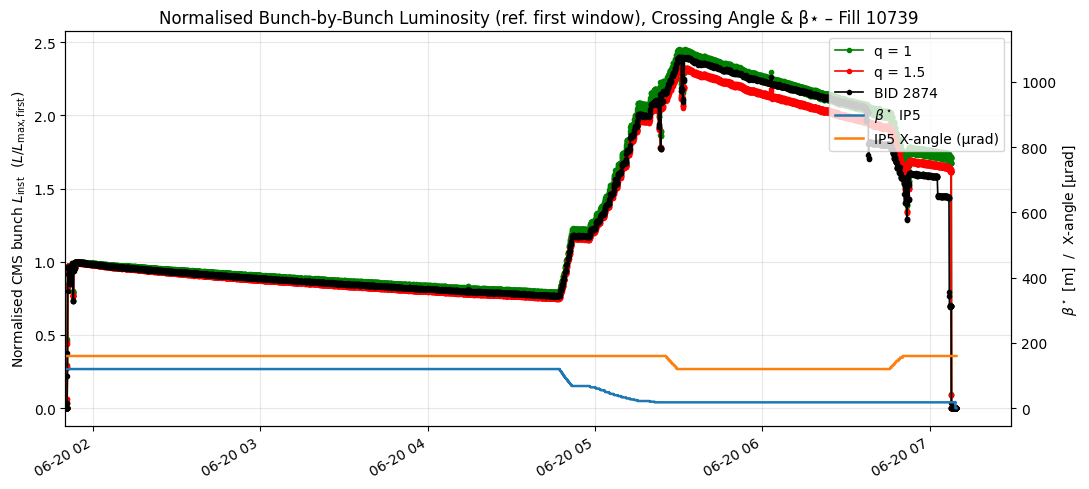

In [309]:
# ────────────────────────────────────────────────────────────────────
# Normalise the *entire CMS fill* to the first-window peak of each bunch
# ────────────────────────────────────────────────────────────────────

# 1) reference maxima from the first split (β⋆ flat → t_change)
max_first_cms = df_cms.loc[t0:t_change].max()

# 2) normalise the *entire* df_cms by those maxima
df_norm_all_cms = df_cms.div(max_first_cms)

# 3) plot – same layout as original, but with *_cms suffixes
pad_cms    = 0.05  # 5% head- & foot-room
ymin_cms   = df_norm_all_cms.min().min()
ymax_cms   = df_norm_all_cms.max().max()
yrange_cms = ymax_cms - ymin_cms
ylow_cms   = ymin_cms - pad_cms * yrange_cms
yhigh_cms  = ymax_cms + pad_cms * yrange_cms

fig_cms, ax_l_cms = plt.subplots(figsize=(11, 5))

# Left axis – normalised bunch curves
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm_all_cms[[f"B{b}" for b in bids]].plot(
        ax=ax_l_cms, color=colour, lw=1.2, marker=".", legend=False
    )

# Solo bunch
ax_l_cms.plot(
    df_norm_all_cms.index,
    df_norm_all_cms[f"B{SOLO_BID}"],
    color="black",
    lw=1.2,
    marker=".",
    label="_nolegend_"
)

ax_l_cms.set_ylabel(
    r"Normalised CMS bunch $L_{\rm inst}$  ($L/L_{\max,\mathrm{first}}$)"
)
ax_l_cms.set_ylim(ylow_cms, yhigh_cms)
ax_l_cms.set_title(
    "Normalised Bunch-by-Bunch Luminosity (ref. first window), "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l_cms.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle (CMS: IP5)
ax_r_cms = ax_l_cms.twinx()
df_beta[BETASTAR_PV].plot(
    ax=ax_r_cms, color="tab:blue", lw=1.8, label=r"$\beta^\star$ IP5"
)
df_xing[XING_PV].plot(
    ax=ax_r_cms, color="tab:orange", lw=1.8, label=r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# Combined legend
handles_cms = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r_cms.lines[0],
    ax_r_cms.lines[1],
]
ax_l_cms.legend(handles=handles_cms, loc="upper right")

# Optional x-range zoom
ax_l_cms.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


/tmp/ipykernel_3339217/1286413954.py:4: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_all_cms[col].values, t_sec_all_cms, initial=0.0)


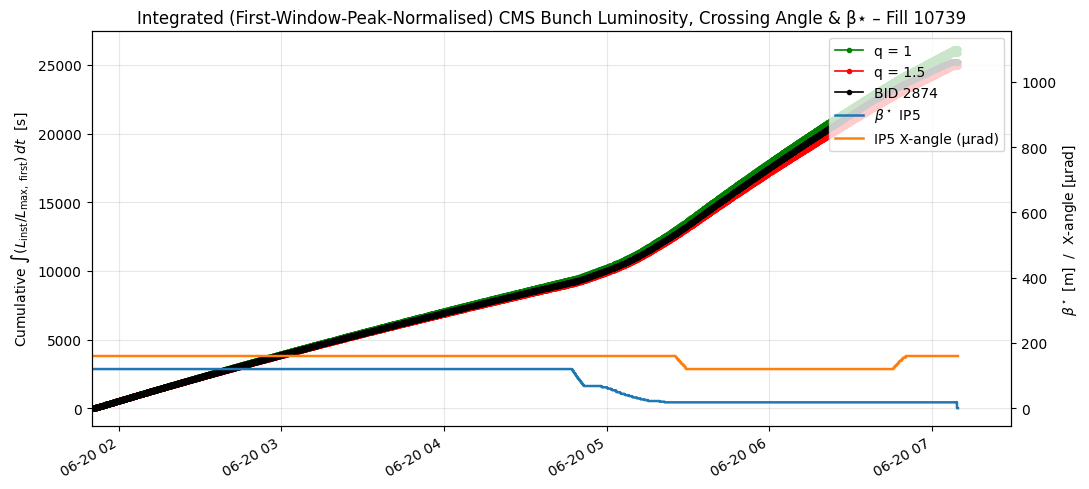

In [310]:
# 1) cumulative integral for each bunch (with *_cms suffixes)
t_sec_all_cms = (df_norm_all_cms.index - df_norm_all_cms.index[0]).total_seconds()
df_cum_all_cms = pd.DataFrame(
    {col: cumtrapz(df_norm_all_cms[col].values, t_sec_all_cms, initial=0.0)
     for col in df_norm_all_cms.columns},
    index=df_norm_all_cms.index
)

# 2) dynamic y-range with 5% padding
pad_cms       = 0.05
ymin_cms      = df_cum_all_cms.min().min()
ymax_cms      = df_cum_all_cms.max().max()
yrange_cms    = ymax_cms - ymin_cms
ylow_cms      = ymin_cms - pad_cms * yrange_cms
yhigh_cms     = ymax_cms + pad_cms * yrange_cms

# 3) plot
fig_int_cms, ax_l_cms = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_max,first) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_all_cms[[f"B{b}" for b in bids]].plot(
        ax=ax_l_cms, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch
ax_l_cms.plot(
    df_cum_all_cms.index,
    df_cum_all_cms[f"B{SOLO_BID}"],
    color="black",
    lw=1.2,
    marker=".",
    label="_nolegend_"
)

ax_l_cms.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_l_cms.set_ylim(ylow_cms, yhigh_cms)
ax_l_cms.set_title(
    "Integrated (First-Window-Peak-Normalised) CMS Bunch Luminosity, "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l_cms.grid(alpha=0.3)

# right axis – β⋆ and X-angle (CMS: IP5)
ax_r_cms = ax_l_cms.twinx()
df_beta[BETASTAR_PV].plot(
    ax=ax_r_cms, color="tab:blue", lw=1.8, label=r"$\beta^\star$ IP5"
)
df_xing[XING_PV].plot(
    ax=ax_r_cms, color="tab:orange", lw=1.8, label=r"IP5 X-angle (µrad)"
)
ax_r_cms.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# legend
handles_cms = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r_cms.lines[0],
    ax_r_cms.lines[1],
]
ax_l_cms.legend(handles=handles_cms, loc="upper right")

# x-range zoom
ax_l_cms.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


In [329]:
# ─────────────────────────────────────────────────────────────────────
# CMS: Peak-normalised cumulative luminosity over the entire fill
# ─────────────────────────────────────────────────────────────────────

final_values_norm_all_cms = df_cum_all_cms.iloc[-1]  # units: seconds

print("CMS: Peak-normalised cumulative luminosity delivered over the whole fill:\n")
print(final_values_norm_all_cms.to_string(float_format="%.3e"))

def sym_pct_diff_all_cms(a, b):
    """
    Symmetric % difference between a and b:
      100 * (b - a) / ((a + b) / 2)
    """
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff_all_cms(ref, comp):
    """
    Relative % difference of comp vs. ref:
      100 * (comp - ref) / ref
    """
    return 100 * (comp - ref) / ref

# --- Individual bunches ---
final_vals_norm_all_cms = df_cum_all_cms.iloc[-1]

# q = 1
L20_all_cms, L500_all_cms = final_vals_norm_all_cms["B20"], final_vals_norm_all_cms["B500"]
rel_20_500_all_cms = rel_pct_diff_all_cms(L20_all_cms, L500_all_cms)
sym_20_500_all_cms = sym_pct_diff_all_cms(L20_all_cms, L500_all_cms)

# q = 1.5
L1250_all_cms, L1800_all_cms = final_vals_norm_all_cms["B1250"], final_vals_norm_all_cms["B1800"]
rel_1250_1800_all_cms = rel_pct_diff_all_cms(L1250_all_cms, L1800_all_cms)
sym_1250_1800_all_cms = sym_pct_diff_all_cms(L1250_all_cms, L1800_all_cms)

print("\nCMS: Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  B20   : {L20_all_cms   : .3e} s")
print(f"  B500  : {L500_all_cms  : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_all_cms :8.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_all_cms :8.4f} %\n")

print(f"  B1250 : {L1250_all_cms : .3e} s")
print(f"  B1800 : {L1800_all_cms : .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_all_cms :8.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_all_cms :8.4f} %")

# --- Mean of each group ---
mean_q1_all_cms  = final_vals_norm_all_cms[["B20", "B500"]].mean()
mean_q15_all_cms = final_vals_norm_all_cms[["B1250", "B1800"]].mean()

rel_mean_all_cms = rel_pct_diff_all_cms(mean_q1_all_cms,  mean_q15_all_cms)
sym_mean_all_cms = sym_pct_diff_all_cms(mean_q1_all_cms,  mean_q15_all_cms)

print("\nCMS: Mean peak-normalised cumulative luminosity over the whole fill:\n")
print(f"  q = 1   mean (B20 & B500)   : {mean_q1_all_cms  : .3e} s")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15_all_cms : .3e} s")
print(f"\n  Relative  % diff (ref q = 1 mean): {rel_mean_all_cms:8.4f} %")
print(f"  Symmetric % diff:                  {sym_mean_all_cms:8.4f} %")

# --- Total of each group ---
group_q1_all_cms   = ["B20", "B500"]
group_q15_all_cms  = ["B1250", "B1800"]

tot_q1_all_cms  = final_vals_norm_all_cms[group_q1_all_cms].sum()
tot_q15_all_cms = final_vals_norm_all_cms[group_q15_all_cms].sum()

rel_tot_all_cms = rel_pct_diff_all_cms(tot_q1_all_cms,  tot_q15_all_cms)
sym_tot_all_cms = sym_pct_diff_all_cms(tot_q1_all_cms, tot_q15_all_cms)

print("\nCMS: Total peak-normalised cumulative luminosity over the whole fill:\n")
print(f"  q = 1   total (B20 + B500)   : {tot_q1_all_cms  : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_all_cms : .3e} s")
print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_all_cms:18.10f} %")
print(f"  Symmetric % diff:                    {sym_tot_all_cms:8.4f} %")


CMS: Peak-normalised cumulative luminosity delivered over the whole fill:

B20     2.614e+04
B500    2.588e+04
B1250   2.499e+04
B1800   2.490e+04
B2874   2.524e+04

CMS: Peak-normalised cumulative luminosity over the whole fill (seconds):

  B20   :  2.614e+04 s
  B500  :  2.588e+04 s
    →  relative % diff (ref B20):    -1.0045 %
    →  symmetric % diff:             -1.0096 %

  B1250 :  2.499e+04 s
  B1800 :  2.490e+04 s
    →  relative % diff (ref B1250):  -0.3858 %
    →  symmetric % diff:             -0.3865 %

CMS: Mean peak-normalised cumulative luminosity over the whole fill:

  q = 1   mean (B20 & B500)   :  2.601e+04 s
  q = 1.5 mean (B1250 & B1800):  2.494e+04 s

  Relative  % diff (ref q = 1 mean):  -4.0928 %
  Symmetric % diff:                   -4.1783 %

CMS: Total peak-normalised cumulative luminosity over the whole fill:

  q = 1   total (B20 + B500)   :  5.202e+04 s
  q = 1.5 total (B1250 + B1800):  4.989e+04 s

  Relative  % diff (ref q = 1 total):      -4.092789756

In [330]:
print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_all:18.10f} %")


  Relative  % diff (ref q = 1 total):      -4.0927897562 %


In [ ]:
id(df_atlas)


140120332468912

In [328]:
id(df_cms)

140120755336000

## AVERAGE

In [312]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST"
CMS_PV   = "CMS:BUNCH_LUMI_INST"
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
dynamic_ylim = True  # Enable dynamic y-axis scaling
title_suffix = "Full window with dynamic y-limit"
def load_bunch_array(pv_name: str, bid_list):
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat    = np.stack(raw[pv_name].values)  # nTimes × 3564
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]
df_atlas = load_bunch_array(ATLAS_PV, all_bids)
df_cms = load_bunch_array(CMS_PV, all_bids)
df_atlas.dropna().head(400)
df_cms.dropna().head(5000)

,B20,B500,B1250,B1800,B2874
2025-06-20 00:35:28.226,-0.000667,-0.000130,-0.000185,-0.000181,-0.000056
2025-06-20 00:35:31.184,-0.000625,-0.000092,-0.000390,-0.000158,0.000034
2025-06-20 00:35:32.607,-0.000902,0.000071,-0.000077,0.000020,0.000198
2025-06-20 00:35:34.136,-0.000889,-0.000024,-0.000128,0.000072,0.000164
2025-06-20 00:35:35.560,-0.000595,0.000075,0.000077,-0.000068,0.000136
...,...,...,...,...,...
2025-06-20 03:31:56.689,7.827207,8.019680,7.073236,7.002639,4.239500
2025-06-20 03:32:05.429,7.799967,7.966847,7.034533,7.035689,4.245155
2025-06-20 03:32:08.274,7.802818,7.991335,7.054686,7.000748,4.246287
2025-06-20 03:32:27.206,7.800551,7.981526,7.060554,7.014068,4.243960


In [313]:
df_clean_atlas = df_atlas.dropna(how="all")
print(df_clean_atlas.index.min(), "→", df_clean_atlas.index.max())
print("rows:", len(df_clean_atlas))
df_clean_atlas.head(20)      # first 20 rows that remain
df_clean_atlas.tail(20) 

2025-06-20 00:35:28.287011 → 2025-06-20 07:09:11.673770
rows: 411


,B20,B500,B1250,B1800,B2874
2025-06-20 06:54:02.875897,15.865439,15.930813,14.166520,14.042031,8.142056
2025-06-20 06:55:02.873353,15.828256,15.997957,14.095731,14.052160,8.151595
2025-06-20 06:56:02.914007,15.778888,15.897902,14.082057,13.984247,8.102481
2025-06-20 06:57:02.963743,15.812988,15.884840,14.125221,13.979012,8.122189
2025-06-20 06:58:03.037770,15.766795,15.878925,14.158950,14.051833,8.131289
2025-06-20 06:58:13.464215,15.701755,15.769201,14.052886,13.827621,7.986762
2025-06-20 06:58:23.640644,15.764523,15.986656,14.130132,13.989771,8.214817
2025-06-20 06:59:23.652622,15.719142,15.790117,14.057834,13.994493,8.107171
2025-06-20 07:00:23.607260,15.700627,15.780925,14.036463,13.921906,8.126078
2025-06-20 07:01:23.708434,15.703138,15.786090,14.000347,13.911194,8.081278


In [314]:
df_clean_cms = df_cms.dropna(how="all")
print(df_clean_cms.index.min(), "→", df_clean_cms.index.max())
print("rows:", len(df_clean_cms))
#df_clean_cms.head(20)      # first 20 rows that remain
df_clean_cms.tail(100) 
# how many NaNs per column?
df_cms.isna().sum()
len(df_cms.dropna())
# After the first cleaning line – run these BEFORE any re-indexing
df_clean_atlas = df_atlas.dropna(how="all")

print("df_clean_atlas shape:", df_clean_atlas.shape)
print(df_clean_atlas.head())          # should show real numbers
print(df_clean_atlas.isna().sum())    # ideally a few NaNs per bunch, not all


2025-06-20 00:35:28.226000 → 2025-06-20 07:09:37.731000
rows: 8435
df_clean_atlas shape: (411, 5)
                                 B20      B500     B1250     B1800     B2874
2025-06-20 00:35:28.287011  0.001948  0.001782  0.001575  0.001824  0.001782
2025-06-20 00:36:28.281640  0.001493  0.001949  0.001285  0.001741  0.001824
2025-06-20 00:37:28.389246  0.001575  0.001575  0.002072  0.002031  0.001575
2025-06-20 00:38:28.388509  0.002197  0.001658  0.001741  0.001617  0.001451
2025-06-20 00:39:28.488797  0.001741  0.001948  0.001451  0.001865  0.001492
B20      0
B500     0
B1250    0
B1800    0
B2874    0
dtype: int64


In [315]:
# 1. clean
df_clean_atlas = df_atlas.dropna(how="all")
df_clean_cms   = df_cms  .dropna(how="all")

# 2. build the grid
time_grid = pd.date_range(
    min(df_clean_atlas.index.min(), df_clean_cms.index.min()),
    max(df_clean_atlas.index.max(), df_clean_cms.index.max()),
    freq="T"
)

# 3. align & fill
atlas_sync = (df_clean_atlas
              .reindex(time_grid)
              .interpolate(method="time")
              .ffill()
              .bfill())

cms_sync   = (df_clean_cms
              .reindex(time_grid)
              .interpolate(method="time")
              .ffill()
              .bfill())

print("NaNs in ATLAS:", atlas_sync.isna().sum().sum())
print("NaNs in CMS:",   cms_sync.isna().sum().sum())


NaNs in ATLAS: 1975
NaNs in CMS: 0


In [316]:
# ── A) easiest: round both detectors to whole seconds first ────────────────
atlas_1s = df_clean_atlas.copy()
cms_1s   = df_clean_cms.copy()

atlas_1s.index = atlas_1s.index.round('S')   # 00:35:28.287 → 00:35:28
cms_1s.index   = cms_1s.index.round('S')

# you can round to '100L' (0.1 s) or '10L' (10 ms) if you need finer detail

# ── B) build a common grid AFTER rounding (here: every second) ────────────
t0 = min(atlas_1s.index.min(), cms_1s.index.min())
t1 = max(atlas_1s.index.max(), cms_1s.index.max())
time_grid = pd.date_range(t0, t1, freq='1S')      # one-second cadence
atlas_sync = (atlas_1s
              .reindex(time_grid)          # inserts NaNs where needed
              .interpolate(method='time')  # fills interior gaps
              .ffill().bfill())            # plugs the very ends

cms_sync   = (cms_1s
              .reindex(time_grid)
              .interpolate(method='time')
              .ffill().bfill())

print("NaNs in ATLAS  :", atlas_sync.isna().sum().sum())
print("NaNs in CMS    :", cms_sync.isna().sum().sum())


NaNs in ATLAS  : 0
NaNs in CMS    : 0


### Full, unedited window

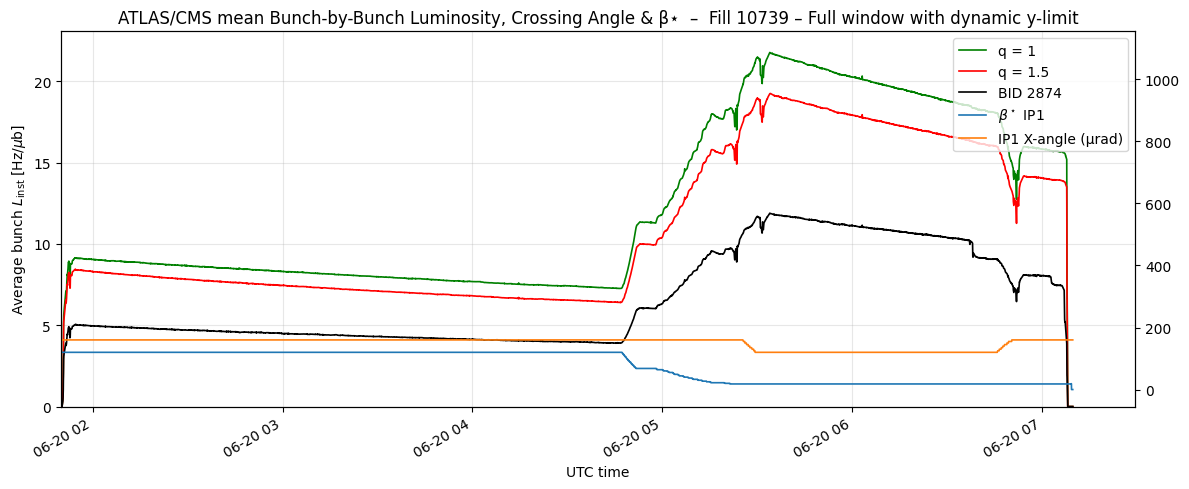

In [317]:
# ════════════════════════════════════════════════════════════════════════════
#  Full one-cell solution: luminosity (left axis) + β*, crossing angle (right)
# ════════════════════════════════════════════════════════════════════════════
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

# ── 0) make sure we have a clean, 1-second grid ─────────────────────────────
t0 = min(atlas_sync.index.min(), cms_sync.index.min())
t1 = max(atlas_sync.index.max(), cms_sync.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")
         # already defined earlier

def load_scalar_series(pv_name):
    """Return a Series resampled to 1-second bins (mean) with a unique index."""
    raw = (dd.read_parquet(DATADIR, columns=[pv_name])
             .dropna()
             .compute())
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    # resample guarantees one value per second (mean if >1 per bin)
    return raw[pv_name].astype(float).resample("1S").mean()

BETASTAR_PV = "HX:BETASTAR_IP1"
XING_PV     = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"

beta_1s = load_scalar_series(BETASTAR_PV)
xing_1s = load_scalar_series(XING_PV)

beta_sync = (beta_1s.reindex(time_grid)
                     .interpolate(method="time")
                     .ffill().bfill())
xing_sync = (xing_1s.reindex(time_grid)
                     .interpolate(method="time")
                     .ffill().bfill())

# ── 2) detector-average luminosity, then group averages ────────────────────
avg_sync = (atlas_sync + cms_sync) / 2.0       # columns: B20, B500, …

group_defs = {
    "q = 1"           : BUNCH_GROUPS["q = 1"][0],       # [20, 500]
    "q = 1.5"         : BUNCH_GROUPS["q = 1.5"][0],     # [1250, 1800]
    f"BID {SOLO_BID}" : [SOLO_BID],                     # [2874]
}
colours = {"q = 1": "green", "q = 1.5": "red", f"BID {SOLO_BID}": "black"}

# ── 3) assemble the plot ───────────────────────────────────────────────────
fig, ax_left = plt.subplots(figsize=(12, 5))

# left-axis: luminosity groups
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax_left.plot(series.index, series.values,
                 label=label, color=colours[label], linewidth=1.2)

ax_left.set_xlabel("UTC time")
ax_left.set_ylabel(r"Average bunch $L_{\rm inst}$ [Hz/$\mu$b]")
ax_left.grid(alpha=0.3)

# optional dynamic y-axis
if dynamic_ylim:
    lo = avg_sync.min().min()
    hi = avg_sync.max().max()
    ax_left.set_ylim(lo * 0.95, hi * 1.05)

# right-axis: β* and crossing angle
ax_right = ax_left.twinx()
ax_right.plot(beta_sync.index, beta_sync.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_sync.index, xing_sync.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")
ax_right.tick_params(axis="y")

# combine legends from both axes
lines_left,  labels_left  = ax_left.get_legend_handles_labels()
lines_right, labels_right = ax_right.get_legend_handles_labels()
ax_left.legend(lines_left + lines_right,
               labels_left + labels_right,
               loc="upper right")

ax_left.set_title(f"ATLAS/CMS mean Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739 – {title_suffix}".strip())
fig.autofmt_xdate()
ax_left.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))
plt.tight_layout()
plt.show()


### Split when beta star changes 

In [318]:
# Step 1: Calculate timestamp 4 hours after start
start_time = beta_sync.index[0]
four_hours_later = start_time + pd.Timedelta(hours=4)

# Step 2: Find first β* change after that time
beta_diff = beta_sync.diff()
post_4h_change = beta_diff[beta_diff != 0]
post_4h_change = post_4h_change[post_4h_change.index > four_hours_later]

# Step 3: Get the first change timestamp after 4 hours
if not post_4h_change.empty:
    first_change_after_4h = post_4h_change.index[0]
    print("First β* change after 4 hours is at:", first_change_after_4h)
else:
    print("No β* change found after 4 hours.")


First β* change after 4 hours is at: 2025-06-20 04:47:13


First β* change after 4 hours at: 2025-06-20 04:47:13


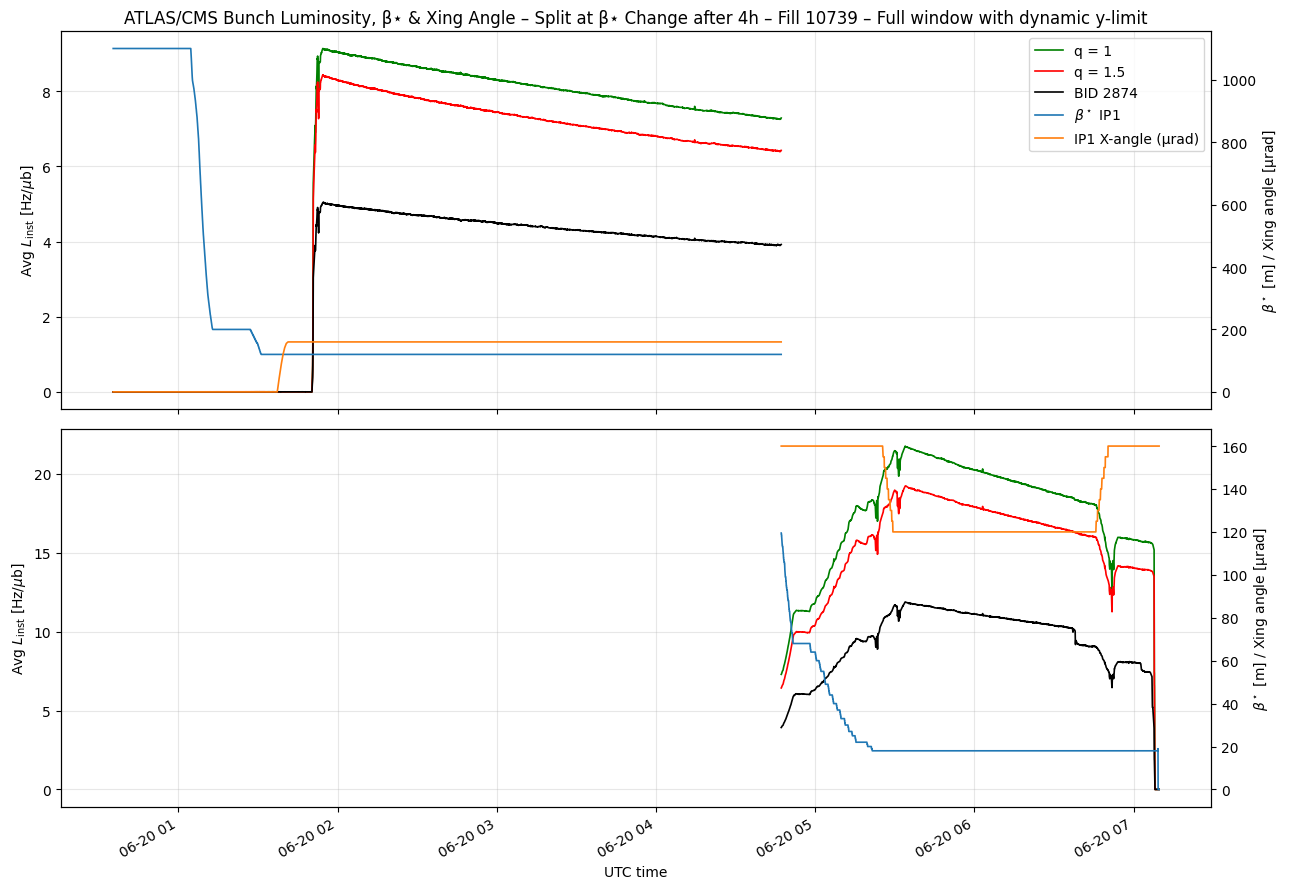

In [319]:
# Step 1: Find β* change after 4 hours
start_time = beta_sync.index[0]
four_hours_later = start_time + pd.Timedelta(hours=4)

beta_diff = beta_sync.diff()
post_4h_change = beta_diff[(beta_diff != 0) & (beta_diff.index > four_hours_later)]

if post_4h_change.empty:
    raise ValueError("No β* change detected after 4 hours.")
change_time = post_4h_change.index[0]
print("First β* change after 4 hours at:", change_time)

# Step 2: Define time windows
time_windows = [
    (beta_sync.index[0], change_time),          # Before β* change
    (change_time, beta_sync.index[-1])          # After β* change
]

# Step 3: Plot both windows
fig, axes = plt.subplots(2, 1, figsize=(13, 9), sharex=True)

for i, (start, end) in enumerate(time_windows):
    ax_left = axes[i]

    # Plot luminosity groups
    for label, bids in group_defs.items():
        series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
        sliced = series[(series.index >= start) & (series.index < end)]
        ax_left.plot(sliced.index, sliced.values,
                     label=label, color=colours[label], linewidth=1.2)

    ax_left.set_ylabel(r"Avg $L_{\rm inst}$ [Hz/$\mu$b]")
    ax_left.grid(alpha=0.3)

    # Right axis: β* and X-angle
    ax_right = ax_left.twinx()
    beta_slice = beta_sync[(beta_sync.index >= start) & (beta_sync.index < end)]
    xing_slice = xing_sync[(xing_sync.index >= start) & (xing_sync.index < end)]
    ax_right.plot(beta_slice.index, beta_slice.values,
                  label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
    ax_right.plot(xing_slice.index, xing_slice.values,
                  label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
    ax_right.set_ylabel(r"$\beta^\star$ [m] / Xing angle [µrad]")

    # Add legends only to first plot
    if i == 0:
        lines_l, labels_l = ax_left.get_legend_handles_labels()
        lines_r, labels_r = ax_right.get_legend_handles_labels()
        ax_left.legend(lines_l + lines_r, labels_l + labels_r, loc="upper right")

# Final touches
axes[0].set_title(f"ATLAS/CMS Bunch Luminosity, β⋆ & Xing Angle – Split at β⋆ Change after 4h – Fill 10739 – {title_suffix}")
axes[1].set_xlabel("UTC time")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### Normalize by max

In [320]:
# Step 1: Find global max time among all normalized series in the selected window
norm_start_time = None
max_time_candidates = []

for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    sliced = series[(series.index >= start_time) & (series.index < t_change)]
    normed = sliced / max_values[label]
    max_idx = normed.idxmax()
    max_time_candidates.append(max_idx)

# Use the earliest of all max timestamps to be conservative
norm_start_time = min(max_time_candidates)
print("X-axis will start from:", norm_start_time)

X-axis will start from: 2025-06-20 01:54:31


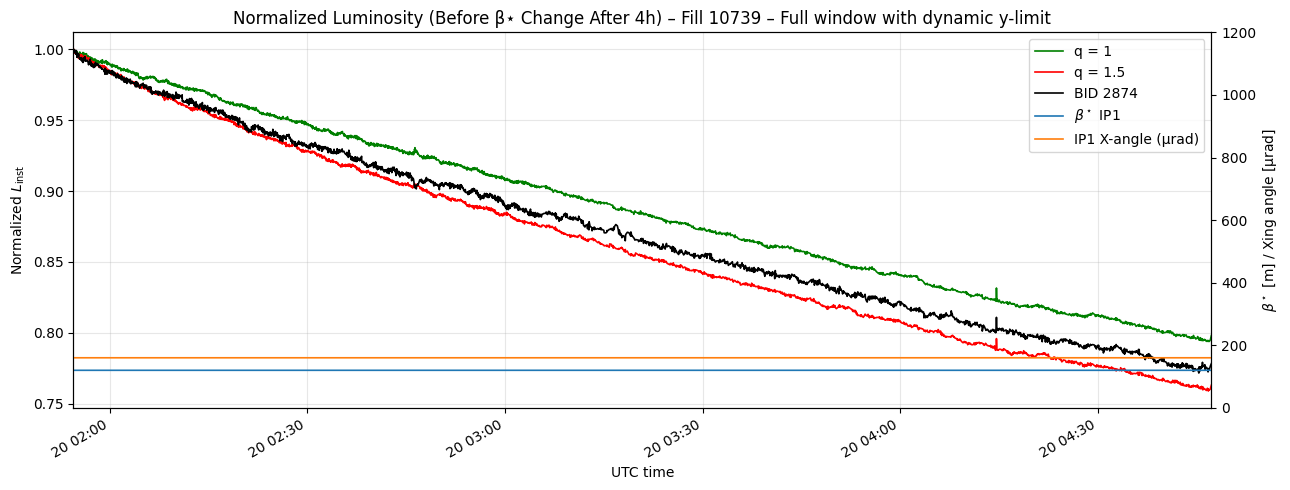

In [ ]:
start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)

# Step 3: Compute max luminosity per group in the window for normalization
max_values = {}
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    window = series[(series.index >= start_time) & (series.index < t_change)]
    max_values[label] = window.max()

# Step 4: Plot
fig, ax_lum = plt.subplots(figsize=(13, 5))

# Left y-axis: Normalized luminosity
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    sliced = series[(series.index >= start_time) & (series.index < t_change)]
    normed = sliced / max_values[label]
    ax_lum.plot(normed.index, normed.values,
                label=label, color=colours[label], linewidth=1.2)

ax_lum.set_ylabel(r"Normalized $L_{\rm inst}$")
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim([norm_start_time, t_change])

# Right y-axis: β* and crossing angle (not normalized)
ax_right = ax_lum.twinx()
beta_slice = beta_sync[(beta_sync.index >= start_time) & (beta_sync.index < t_change)]
xing_slice = xing_sync[(xing_sync.index >= start_time) & (xing_sync.index < t_change)]
ax_right.plot(beta_slice.index, beta_slice.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_slice.index, xing_slice.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m] / Xing angle [µrad]")

# Combine legends
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper right")

# Final polish
ax_right.set_ylim(0, 1200)
ax_lum.set_title(f"Normalized Luminosity (Before β⋆ Change After 4h) – Fill 10739 – {title_suffix}")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Integrated normalized luminosity

/tmp/ipykernel_3339217/3943594440.py:39: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)


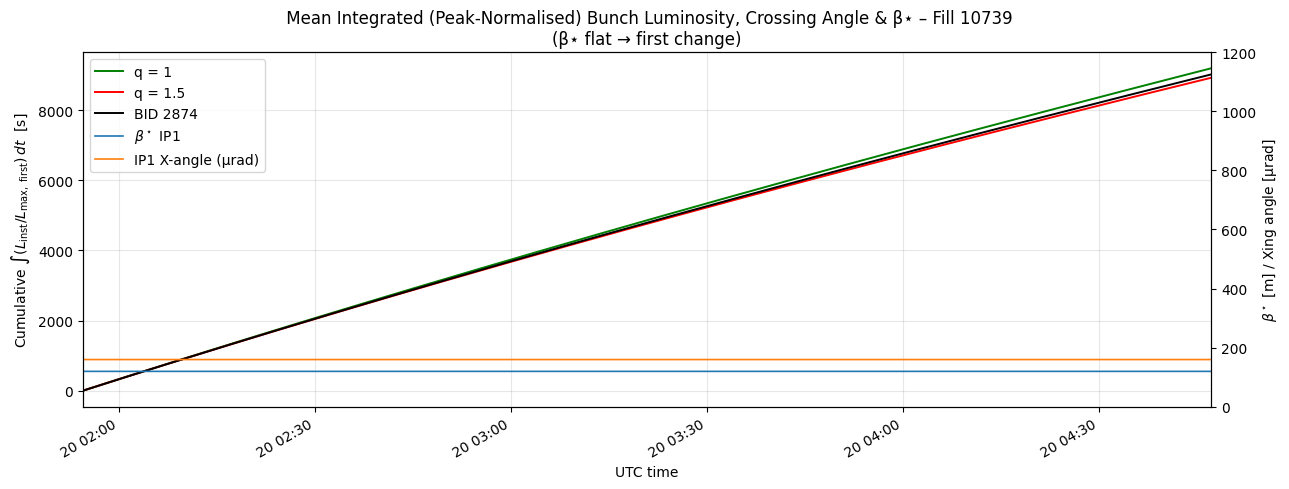

In [322]:
from scipy.integrate import cumtrapz

# Step 1: Find β* change after 4 hours
start_time_full = beta_sync.index[0]
four_hours_later = start_time_full + pd.Timedelta(hours=4)

beta_diff = beta_sync.diff()
post_4h_change = beta_diff[(beta_diff != 0) & (beta_diff.index > four_hours_later)]

if post_4h_change.empty:
    raise ValueError("No β* change detected after 4 hours.")
t_change = post_4h_change.index[0]

# Step 2: Custom x-axis start (based on max normalized L_inst)
start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)

# Compute max in window for normalization
max_values = {}
max_time_candidates = []
norm_series_dict = {}

for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    sliced = series[(series.index >= start_time) & (series.index < t_change)]
    max_values[label] = sliced.max()
    normed = sliced / max_values[label]
    norm_series_dict[label] = normed
    max_time_candidates.append(normed.idxmax())

# Start x-axis from earliest peak
norm_start_time = min(max_time_candidates)

# Step 3: Plot cumulative integrated luminosity
fig, ax_lum = plt.subplots(figsize=(13, 5))

for label, normed in norm_series_dict.items():
    normed = normed[normed.index >= norm_start_time]
    times_sec = (normed.index - normed.index[0]).total_seconds()
    integrated = cumtrapz(normed.values, times_sec, initial=0)
    ax_lum.plot(normed.index, integrated,
                label=label, color=colours[label], linewidth=1.4)
ax_lum.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim([norm_start_time, t_change])

# Step 4: Plot β* and crossing angle (right y-axis, unchanged)
ax_right = ax_lum.twinx()
beta_slice = beta_sync[(beta_sync.index >= norm_start_time) & (beta_sync.index < t_change)]
xing_slice = xing_sync[(xing_sync.index >= norm_start_time) & (xing_sync.index < t_change)]
ax_right.plot(beta_slice.index, beta_slice.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_slice.index, xing_slice.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m] / Xing angle [µrad]")
ax_right.set_ylim(0, 1200)

# Combine legends
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper left")

# Title and finish
#ax_lum.set_title(f"Cumulative Integrated Normalized Luminosity – Fill 10739 – {title_suffix}")
ax_lum.set_title(
    " Mean Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### Statistics

In [323]:
# Utility functions
def sym_pct_diff(a, b):
    return 100 * abs(a - b) / ((a + b) / 2)

def rel_pct_diff(ref, val):
    return 100 * (val - ref) / ref

# Rebuild cumulative DataFrame using group-averaged curves
df_cum_norm = pd.DataFrame()

for label, normed in norm_series_dict.items():
    normed = normed[normed.index >= norm_start_time]
    times_sec = (normed.index - normed.index[0]).total_seconds()
    integrated = cumtrapz(normed.values, times_sec, initial=0)
    df_cum_norm[label] = pd.Series(integrated, index=normed.index)

# Trim to β* change time
df_cum_norm = df_cum_norm[df_cum_norm.index <= t_change]
final_values_norm = df_cum_norm.iloc[-1]

print("\nPeak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm.to_string(float_format="%.3e"))

# Ensure keys match what's available
print("\nAvailable group labels:", final_values_norm.index.tolist())

# Group labels to compare
label_q1 = "q = 1"
label_q15 = "q = 1.5"

# Check they exist
if label_q1 not in final_values_norm or label_q15 not in final_values_norm:
    raise ValueError("Expected group labels not found in final results.")

# Extract values
val_q1 = final_values_norm[label_q1]
val_q15 = final_values_norm[label_q15]

# Compare total (same as mean in this case since one curve per group)
sym_pct = sym_pct_diff(val_q1, val_q15)
rel_pct = rel_pct_diff(val_q1, val_q15)

print("\nPeak-normalised cumulative luminosity at β⋆ change (GROUP LEVEL):")
print(f"  q = 1 (avg B20 + B500):      {val_q1 : .3e}  s")
print(f"  q = 1.5 (avg B1250 + B1800): {val_q15: .3e}  s")
print(f"  Symmetric % difference:      {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")



Peak-normalised cumulative luminosity delivered up to β⋆ change:
q = 1      9.195e+03
q = 1.5    8.924e+03
BID 2874   9.020e+03

Available group labels: ['q = 1', 'q = 1.5', 'BID 2874']

Peak-normalised cumulative luminosity at β⋆ change (GROUP LEVEL):
  q = 1 (avg B20 + B500):       9.195e+03  s
  q = 1.5 (avg B1250 + B1800):  8.924e+03  s
  Symmetric % difference:      2.984 %
  Relative  % difference (ref q=1): -2.940 %


/tmp/ipykernel_3339217/559629590.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/559629590.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/559629590.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)


### Full window Normalization

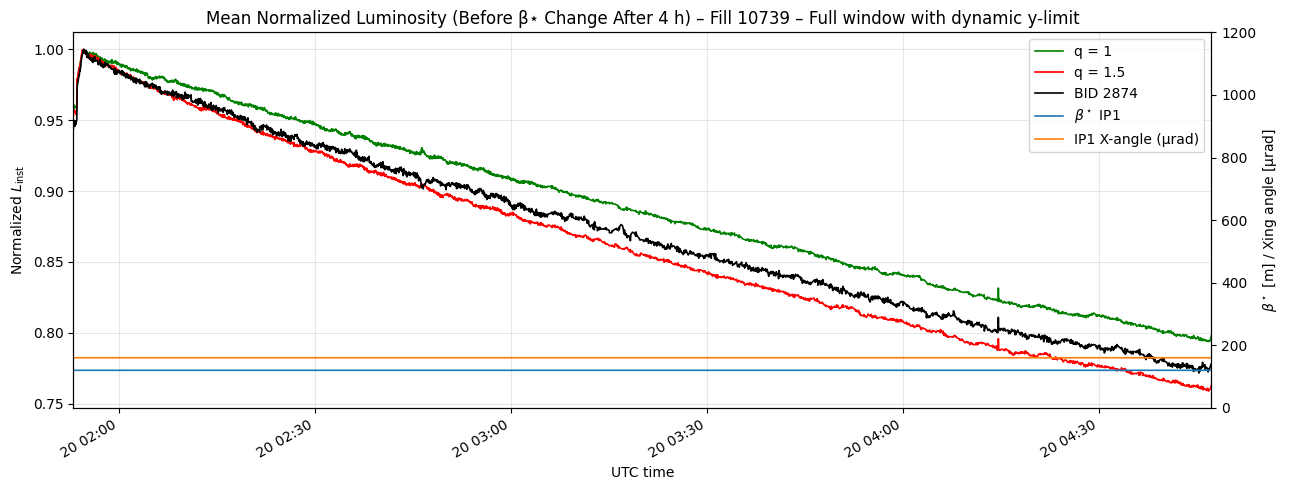

In [324]:
# ――― 1)  Reference-window max (unchanged) ―――
start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)

max_values = {}
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ref_window = series[(series.index >= start_time) & (series.index < t_change)]
    max_values[label] = ref_window.max()

# ――― 2)  Plot from start_time → t_change ―――
fig, ax_lum = plt.subplots(figsize=(13, 5))

for label, bids in group_defs.items():
    series      = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    full_slice  = series[(series.index >= start_time) & (series.index < t_change)]  # ← changed line
    normed      = full_slice / max_values[label]

    ax_lum.plot(full_slice.index, normed.values,
                label=label, color=colours[label], linewidth=1.2)

ax_lum.set_ylabel(r"Normalized $L_{\rm inst}$")
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim([start_time, t_change])                    # ← changed line

# ――― 3)  Secondary axis (same time slice) ―――
ax_right = ax_lum.twinx()
beta_slice = beta_sync[(beta_sync.index >= start_time) & (beta_sync.index < t_change)]
xing_slice = xing_sync[(xing_sync.index >= start_time) & (xing_sync.index < t_change)]

ax_right.plot(beta_slice.index, beta_slice.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_slice.index, xing_slice.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m] / Xing angle [µrad]")

# ――― 4)  Legend & cosmetics (unchanged) ―――
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper right")

ax_right.set_ylim(0, 1200)
ax_lum.set_title(f"Mean Normalized Luminosity (Before β⋆ Change After 4 h) – Fill 10739 – {title_suffix}")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### Integrated Luminosity for whole window

/tmp/ipykernel_3339217/3044957715.py:27: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_int     = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/3044957715.py:27: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_int     = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/3044957715.py:27: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_int     = cumtrapz(normed.values, times_sec, initial=0)


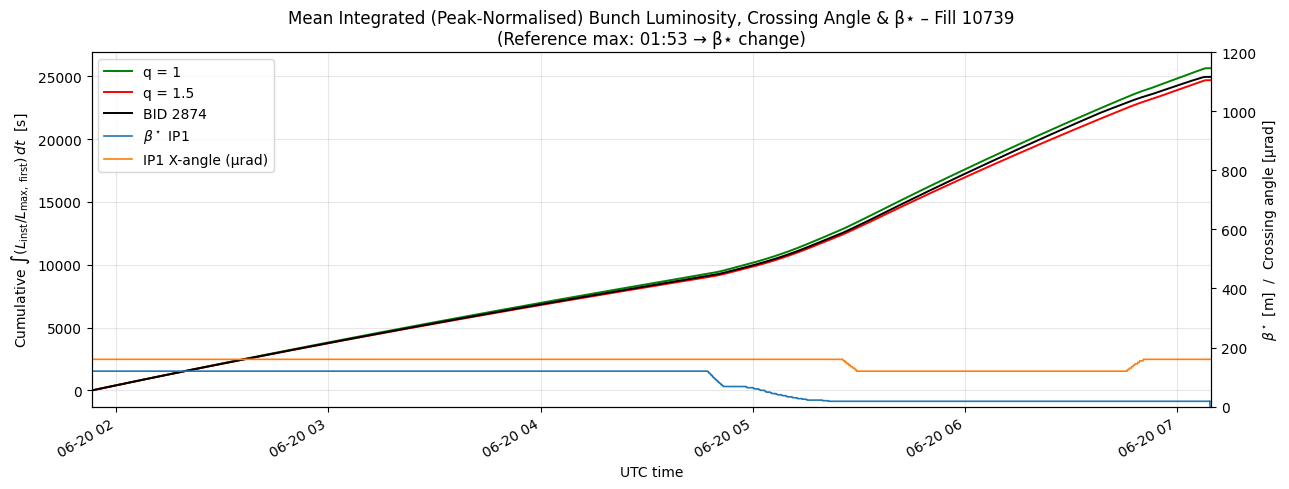

In [325]:
# 1) Compute the reference max for each bunch-group (01:53 → t_change)
start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)

max_values = {}
for label, bids in group_defs.items():
    series_ref = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ref_slice  = series_ref[(series_ref.index >= start_time) &
                            (series_ref.index <  t_change)]
    max_values[label] = ref_slice.max()

# 2) Determine the full integration window
norm_start_time = start_time
end_time        = avg_sync.index[-1]    # last timestamp in your data

# 3) Build and plot the cumulative integral over the whole window
fig, ax_lum = plt.subplots(figsize=(13, 5))

for label, bids in group_defs.items():
    # fetch & normalise the full slice
    series_full = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    normed      = (series_full[(series_full.index >= norm_start_time) &
                               (series_full.index <= end_time)]
                   / max_values[label])

    # elapsed seconds from the first point
    times_sec   = (normed.index - normed.index[0]).total_seconds()
    cum_int     = cumtrapz(normed.values, times_sec, initial=0)

    ax_lum.plot(normed.index, cum_int,
                label=label, color=colours[label], linewidth=1.4)

# styling left axis
ax_lum.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim([norm_start_time, end_time])

# 4) Secondary axis: β⋆ and crossing angle over the same full window
ax_right = ax_lum.twinx()
beta_full = beta_sync[(beta_sync.index >= norm_start_time) &
                      (beta_sync.index <= end_time)]
xing_full = xing_sync[(xing_sync.index >= norm_start_time) &
                      (xing_sync.index <= end_time)]

ax_right.plot(beta_full.index, beta_full.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_full.index, xing_full.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m]  /  Crossing angle [µrad]")
ax_right.set_ylim(0, 1200)

# 5) Combine legends & finalize
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper left")

ax_lum.set_title(
    "Mean Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(Reference max: 01:53 → β⋆ change)"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

/tmp/ipykernel_3339217/2380150575.py:33: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/2380150575.py:33: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/2380150575.py:33: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial=0)
/tmp/ipykernel_3339217/2380150575.py:73: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(normed.values, times_sec, initial


Peak-normalised cumulative luminosity delivered up to β⋆ change:
q = 1      9.285e+03
q = 1.5    9.014e+03
BID 2874   9.109e+03

Available group labels: ['q = 1', 'q = 1.5', 'BID 2874']

Peak-normalised cumulative luminosity at β⋆ change (GROUP LEVEL):
  q = 1       :  9.285e+03  s
  q = 1.5     :  9.014e+03  s
  Symmetric % difference:      2.956 %
  Relative  % difference (ref q = 1): -2.913 %


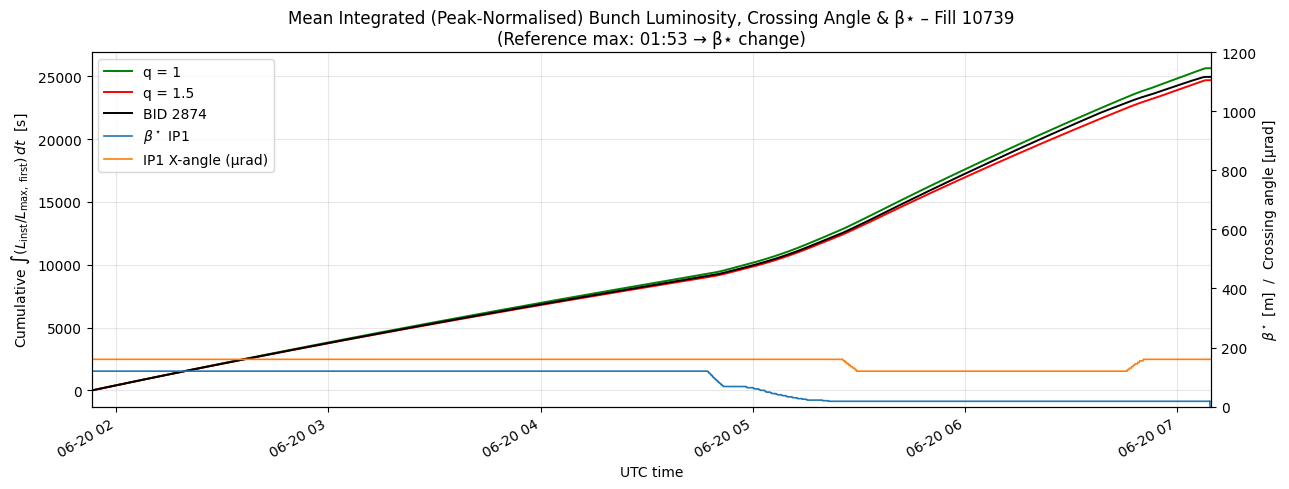

In [326]:

def sym_pct_diff(a, b):
    """Symmetric percent difference between a and b."""
    return 100 * abs(a - b) / ((a + b) / 2)

def rel_pct_diff(ref, val):
    """Relative percent difference of val vs. ref."""
    return 100 * (val - ref) / ref

start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)
max_values = {}
for label, bids in group_defs.items():
    series_ref = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ref_slice  = series_ref[(series_ref.index >= start_time) &
                            (series_ref.index <  t_change)]
    max_values[label] = ref_slice.max()

# Define integration window
norm_start_time = start_time
end_time        = avg_sync.index[-1]

norm_series_dict = {}
for label, bids in group_defs.items():
    series_full = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    full_slice  = series_full[(series_full.index >= norm_start_time) &
                              (series_full.index <= end_time)]
    norm_series_dict[label] = full_slice / max_values[label]

df_cum_norm = pd.DataFrame()
for label, normed in norm_series_dict.items():
    # restrict to ≥ norm_start_time
    normed = normed[normed.index >= norm_start_time]
    times_sec = (normed.index - normed.index[0]).total_seconds()
    integrated = cumtrapz(normed.values, times_sec, initial=0)
    df_cum_norm[label] = pd.Series(integrated, index=normed.index)

# Trim to the β⋆ change point
df_cum_norm = df_cum_norm[df_cum_norm.index <= t_change]
final_values_norm = df_cum_norm.iloc[-1]

print("\nPeak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm.to_string(float_format="%.3e"))

print("\nAvailable group labels:", final_values_norm.index.tolist())


label_q1   = "q = 1"
label_q15  = "q = 1.5"

for lbl in (label_q1, label_q15):
    if lbl not in final_values_norm.index:
        raise ValueError(f"Expected group label '{lbl}' not found.")

val_q1   = final_values_norm[label_q1]
val_q15  = final_values_norm[label_q15]
sym_pct  = sym_pct_diff(val_q1, val_q15)
rel_pct  = rel_pct_diff(val_q1, val_q15)

print("\nPeak-normalised cumulative luminosity at β⋆ change (GROUP LEVEL):")
print(f"  {label_q1:12s}: {val_q1: .3e}  s")
print(f"  {label_q15:12s}: {val_q15: .3e}  s")
print(f"  Symmetric % difference:      {sym_pct:.3f} %")
print(f"  Relative  % difference (ref {label_q1}): {rel_pct:.3f} %")

# ──────────────────────────────────────────────────────────────
# 5) Plot cumulative integrated luminosity (full window)
# ──────────────────────────────────────────────────────────────
fig, ax_lum = plt.subplots(figsize=(13, 5))

for label, normed in norm_series_dict.items():
    # ensure slicing from norm_start_time
    normed = normed[normed.index >= norm_start_time]
    times_sec = (normed.index - normed.index[0]).total_seconds()
    integrated = cumtrapz(normed.values, times_sec, initial=0)

    ax_lum.plot(normed.index, integrated,
                label=label, color=colours[label], linewidth=1.4)

ax_lum.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim([norm_start_time, end_time])

# Secondary axis: β⋆ and crossing angle
ax_right = ax_lum.twinx()
beta_full = beta_sync[(beta_sync.index >= norm_start_time) &
                      (beta_sync.index <= end_time)]
xing_full = xing_sync[(xing_sync.index >= norm_start_time) &
                      (xing_sync.index <= end_time)]

ax_right.plot(beta_full.index, beta_full.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_full.index, xing_full.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m]  /  Crossing angle [µrad]")
ax_right.set_ylim(0, 1200)

# Combine legends
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper left")

ax_lum.set_title(
    "Mean Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(Reference max: 01:53 → β⋆ change)"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
